# [Chapter 5: Making Recommendations](https://mbmlbook.com/Recommender.html)

In [1]:
import warnings
import sys

import arviz as az
import pandas as pd
import numpy as np

import pymc3 as pm
import theano.tensor as tt

import matplotlib.pyplot as plt
import seaborn as sns

%config Completer.use_jedi = False 

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

print(f"Python version: {sys.version}")
print(f"Running on PyMC3 v{pm.__version__}")
print(f"Running on ArviZ v{az.__version__}")

Python version: 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:27:48) 
[Clang 11.1.0 ]
Running on PyMC3 v3.11.4
Running on ArviZ v0.11.4


# 1. Prepare the dataset

https://github.com/dotnet/mbmlbook/tree/main/src/5.%20Making%20Recommendations/Data/MovieLensForEducation

## Load the data

In [3]:
URL_MOVIES = 'https://raw.githubusercontent.com/dotnet/mbmlbook/main/src/5.%20Making%20Recommendations/Data/MovieLensForEducation/movies.csv'
URL_RATINGS = 'https://raw.githubusercontent.com/dotnet/mbmlbook/main/src/5.%20Making%20Recommendations/Data/MovieLensForEducation/ratings.csv'

In [4]:
df_movies = pd.read_csv(URL_MOVIES, sep=';', header=None)
df_movies.columns = ['movie_id', 'movie_name', 'movie_genre']

df_ratings = pd.read_csv(URL_RATINGS, header=None)
df_ratings.columns = ['user_id', 'movie_id', 'movie_rating']

In [5]:
df_movies.head()

movie_id                          movie_name  \
0         1                    Toy Story (1995)   
1         2                      Jumanji (1995)   
2         3             Grumpier Old Men (1995)   
3         4            Waiting to Exhale (1995)   
4         5  Father of the Bride Part II (1995)   

                                   movie_genre  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [6]:
df_movies.movie_id.value_counts().unique()

array([1])

In [7]:
df_movies.tail()

movie_id                                         movie_name  \
9099    162542                                      Rustom (2016)   
9100    162672                                Mohenjo Daro (2016)   
9101    163056                               Shin Godzilla (2016)   
9102    163949  The Beatles: Eight Days a Week - The Touring Y...   
9103    164977                           The Gay Desperado (1936)   

                          movie_genre  
9099                 Romance|Thriller  
9100          Adventure|Drama|Romance  
9101  Action|Adventure|Fantasy|Sci-Fi  
9102                      Documentary  
9103                           Comedy

In [8]:
df_movies.movie_name.nunique(), df_movies.movie_id.nunique()

(9102, 9104)

<AxesSubplot:>

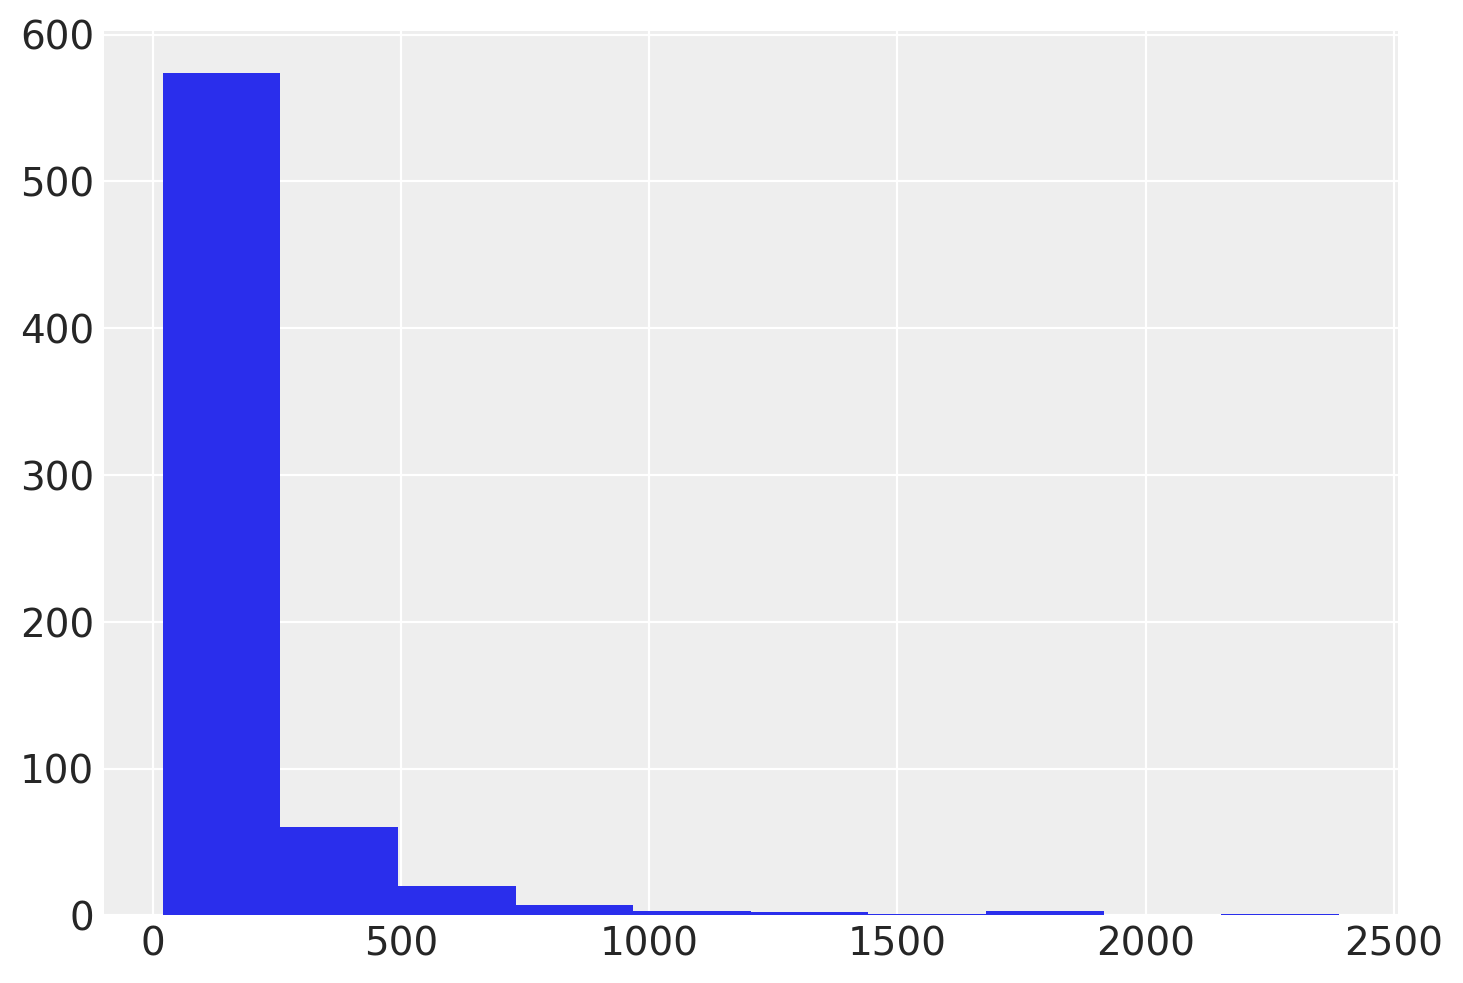

In [9]:
df_ratings.user_id.value_counts().hist()

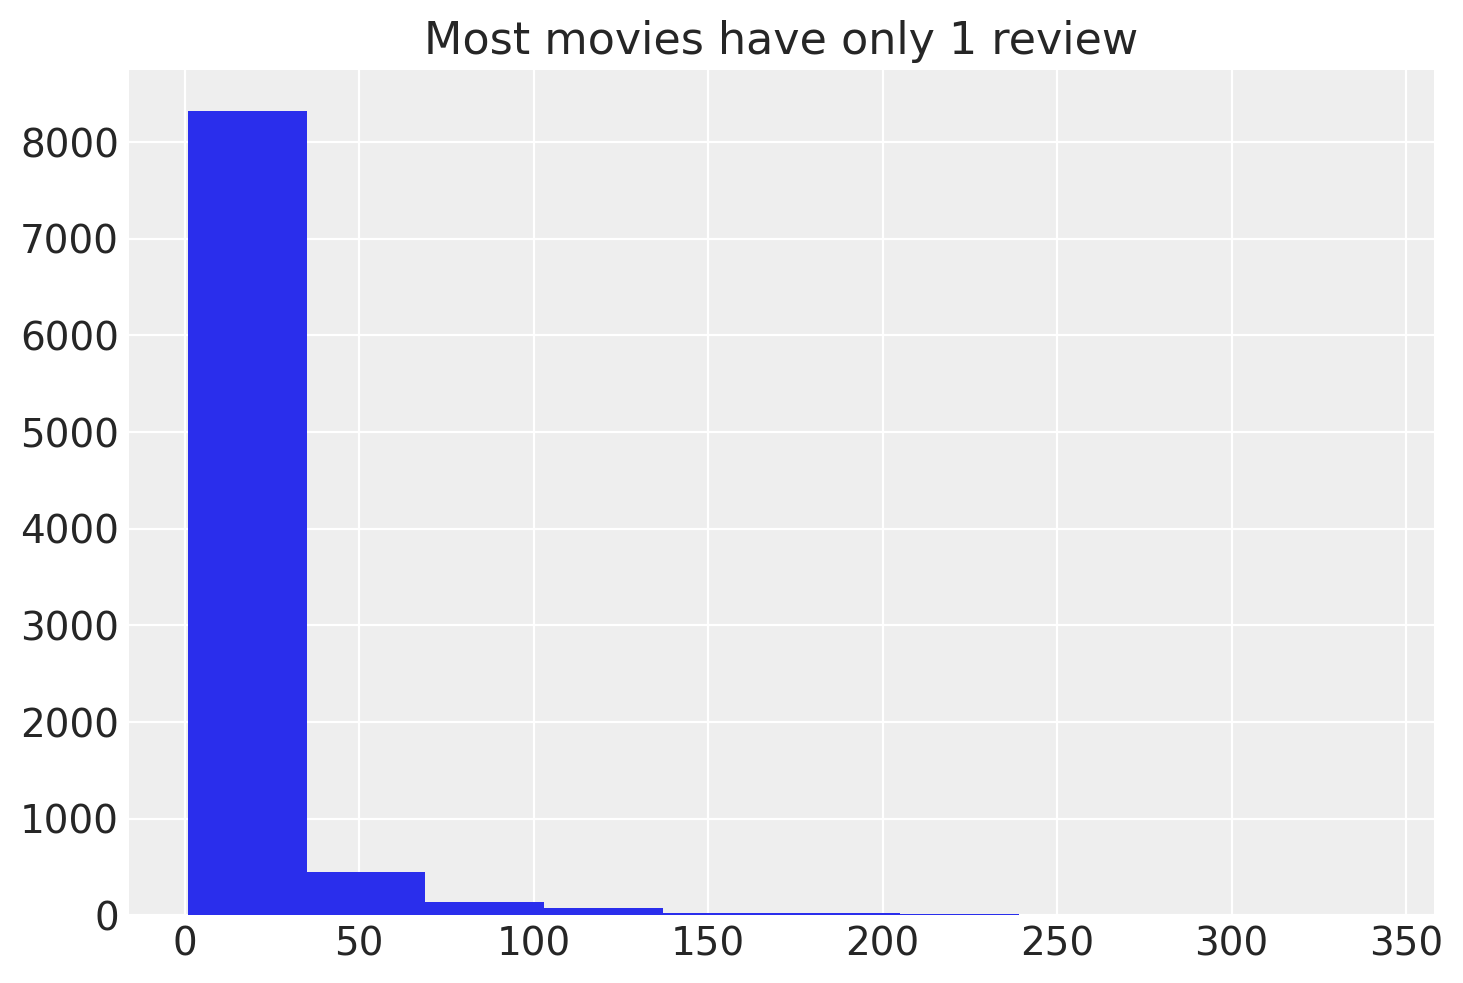

In [10]:
df_ratings.movie_id.value_counts().hist()
_ = plt.title("Most movies have only 1 review")

In [11]:
df_summary = (df_ratings.groupby('movie_id').
              agg({'movie_id': len, 'movie_rating': np.mean}).
              rename(columns={'movie_id': 'n_ratings', 'movie_rating': 'avg_rating'}).
              reset_index()
             )
df_movies = df_movies.merge(df_summary, on='movie_id')

In [12]:
df_movies.sort_values('n_ratings', ascending=False)[:20]

movie_id                                         movie_name  \
321        356                                Forrest Gump (1994)   
266        296                                Pulp Fiction (1994)   
284        318                   Shawshank Redemption, The (1994)   
525        593                   Silence of the Lambs, The (1991)   
232        260          Star Wars: Episode IV - A New Hope (1977)   
427        480                               Jurassic Park (1993)   
2062      2571                                 Matrix, The (1999)   
0            1                                   Toy Story (1995)   
472        527                            Schindler's List (1993)   
522        589                  Terminator 2: Judgment Day (1991)   
953       1196  Star Wars: Episode V - The Empire Strikes Back...   
100        110                                  Braveheart (1995)   
1024      1270                          Back to the Future (1985)   
535        608                                       Fargo (1996)   
955       1198  Raiders of the Lost Ark (Indiana Jones and the...   
2288      2858                             American Beauty (1999)   
644        780               Independence Day (a.k.a. ID4) (1996)   
966       1210  Star Wars: Episode VI - Return of the Jedi (1983)   
521        588                                     Aladdin (1992)   
406        457                               Fugitive, The (1993)   

                                      movie_genre  n_ratings  avg_rating  
321                      Comedy|Drama|Romance|War        341    8.108504  
266                   Comedy|Crime|Drama|Thriller        324    8.512346  
284                                   Crime|Drama        311    8.974277  
525                         Crime|Horror|Thriller        304    8.276316  
232                       Action|Adventure|Sci-Fi        291    8.443299  
427              Action|Adventure|Sci-Fi|Thriller        274    7.412409  
2062                       Action|Sci-Fi|Thriller        259    8.366795  
0     Adventure|Animation|Children|Comedy|Fantasy        247    7.744939  
472                                     Drama|War        244    8.606557  
522                                 Action|Sci-Fi        237    8.012658  
953                       Action|Adventure|Sci-Fi        234    8.465812  
100                              Action|Drama|War        228    7.890351  
1024                      Adventure|Comedy|Sci-Fi        226    8.030973  
535                   Comedy|Crime|Drama|Thriller        224    8.513393  
955                              Action|Adventure        220    8.386364  
2288                                Drama|Romance        220    8.472727  
644              Action|Adventure|Sci-Fi|Thriller        218    6.967890  
966                       Action|Adventure|Sci-Fi        217    8.119816  
521   Adventure|Animation|Children|Comedy|Musical        215    7.348837  
406                                      Thriller        213    7.906103

In [14]:
assert not df_ratings.duplicated(['user_id','movie_id']).any()

In [15]:
df_movies

movie_id                                         movie_name  \
0            1                                   Toy Story (1995)   
1            2                                     Jumanji (1995)   
2            3                            Grumpier Old Men (1995)   
3            4                           Waiting to Exhale (1995)   
4            5                 Father of the Bride Part II (1995)   
...        ...                                                ...   
9042    161918                Sharknado 4: The 4th Awakens (2016)   
9043    161944              The Last Brickmaker in America (2001)   
9044    162542                                      Rustom (2016)   
9045    162672                                Mohenjo Daro (2016)   
9046    163949  The Beatles: Eight Days a Week - The Touring Y...   

                                      movie_genre  n_ratings  avg_rating  
0     Adventure|Animation|Children|Comedy|Fantasy        247    7.744939  
1                      Adventure|Children|Fantasy        107    6.803738  
2                                  Comedy|Romance         59    6.322034  
3                            Comedy|Drama|Romance         13    4.769231  
4                                          Comedy         56    6.535714  
...                                           ...        ...         ...  
9042               Action|Adventure|Horror|Sci-Fi          1    3.000000  
9043                                        Drama          1   10.000000  
9044                             Romance|Thriller          1   10.000000  
9045                      Adventure|Drama|Romance          1    6.000000  
9046                                  Documentary          1   10.000000  

[9047 rows x 5 columns]

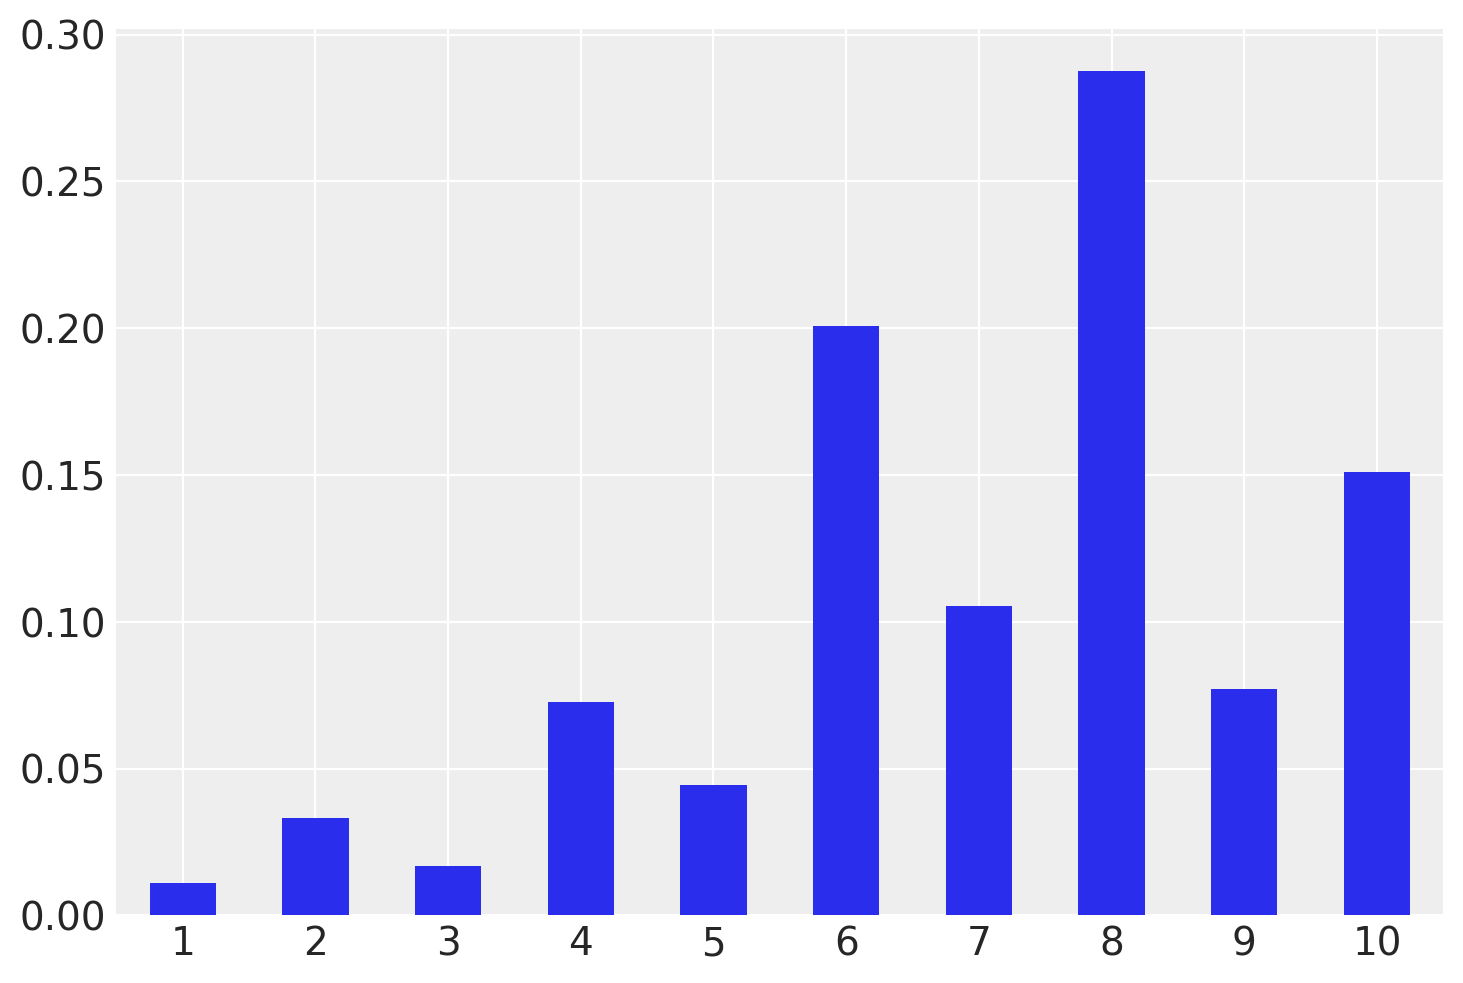

In [16]:
df_ratings.movie_rating.value_counts(normalize=True).sort_index().plot(kind='bar')
_ = plt.xticks(rotation=0)

    "Multiplied the ratings by 2. So the original values that varied from 0.5 to 5 are now 1 to 10. Goes well with the "star" explanation. "
    
https://github.com/dotnet/mbmlbook/tree/main/src/5.%20Making%20Recommendations/Data/MovieLensForEducation

    "we will assume that 3 or more stars means that a person liked the movie, and that 2.5 or fewer stars means they did not like the movie"

## Binarise ratings

In [17]:
df_ratings.loc[:, 'binary_rating'] = np.where(df_ratings.movie_rating >= 6, 1, 0)

In [18]:
df_ratings.binary_rating.mean(), df_ratings.binary_rating.value_counts()

(0.8216614658345335,
 1    82153
 0    17831
 Name: binary_rating, dtype: int64)

In [19]:
len(df_ratings)

99984

## Train/test split

    "We need to split this like/dislike data into a training set for training our model, and a validation set to evaluate recommendations coming from the model. For each person we will use 70% of their likes/dislikes to train on and leave 30% to use for validation. We also remove ratings from the validation set for any movies that do not appear anywhere in the training set (since the trait position for these movies cannot be learned).

In [20]:
df_ratings.user_id.nunique()

671

In [21]:
idx_train = df_ratings.groupby('user_id').sample(frac=0.7, replace=False, random_state=20220926).index
idx_valid = np.setdiff1d(df_ratings.index, idx_train)
MOVIES_TO_REMOVE = np.setdiff1d(df_ratings.loc[idx_valid, 'movie_id'], df_ratings.loc[idx_train, 'movie_id'])

df_valid = df_ratings.loc[(idx_valid)]
idx_valid = df_valid[~df_valid.movie_id.isin(MOVIES_TO_REMOVE)].index

In [22]:
assert len(np.intersect1d(idx_train, idx_valid)) == 0

In [23]:
df_ratings.loc[idx_train].user_id.nunique(), df_ratings.loc[idx_valid].user_id.nunique()

(671, 671)

In [24]:
df_ratings.loc[idx_train, 'movie_id'].nunique(), df_ratings.loc[idx_valid, 'movie_id'].nunique()

(7978, 4759)

In [25]:
df_ratings.loc[idx_train, 'binary_rating'].value_counts()

1    57460
0    12523
Name: binary_rating, dtype: int64

In [26]:
df_ratings.loc[idx_train, 'binary_rating'].value_counts(normalize=True)

1    0.821057
0    0.178943
Name: binary_rating, dtype: float64

In [27]:
df_ratings.loc[idx_valid, 'binary_rating'].value_counts(normalize=True)

1    0.82741
0    0.17259
Name: binary_rating, dtype: float64

In [28]:
cmap_bw = ['#000000', '#FFFFFF']

In [29]:
df_train = df_ratings.loc[idx_train].pivot('movie_id','user_id', 'binary_rating')
df_valid = df_ratings.loc[idx_valid].pivot('movie_id','user_id', 'binary_rating')

<AxesSubplot:xlabel='user_id', ylabel='movie_id'>

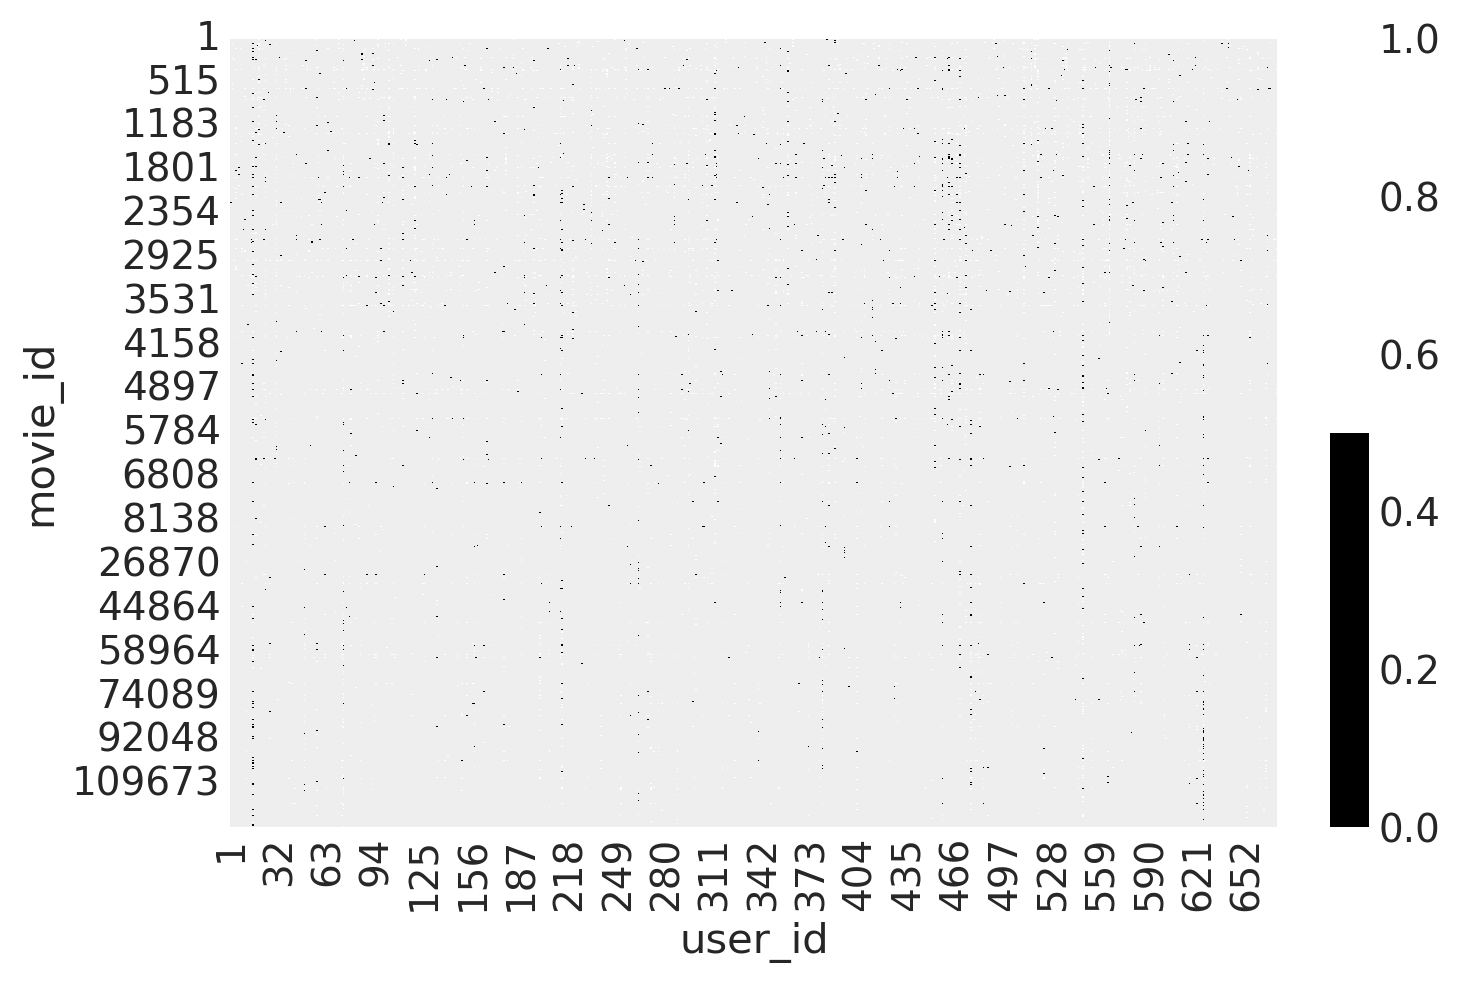

In [30]:
sns.heatmap(df_train, cmap=cmap_bw)

In [31]:
def get_prop_empty(df):
    n_empty = df.isnull().sum().sum()
    n_rows, n_cols = df.shape
    return n_empty / (n_rows * n_cols)

In [32]:
get_prop_empty(df_train)

0.9869269776535249

In [33]:
get_prop_empty(df_valid)

0.9909948645424826

In [34]:
np.setdiff1d(df_valid.index, df_train.index)

array([], dtype=int64)

# 2. Model


## Assumptions

    1. Each movie can be characterized by its position in trait space, represented as a continuous number for each trait.
    
    2. A person’s preferences can be characterized by a position in trait space, again represented as a continuous number for each trait.
    
    3. A positive preference value means that a person prefers movies with positive values of the trait (and vice versa for negative values). The absolute size of the preference value indicates the strength of preference, where zero means indifference.
    
    4.The effect of one trait value on whether a person likes or dislikes a movie is the same, no matter what other trait values that movie has.
    
    5. Whether a person will like or dislike a movie depends only on the movie’s traits and not on anything else.



In [35]:
df_train.head()

user_id   1    2    3    4    5    6    7    8    9    10   ...  662  663  \
movie_id                                                    ...             
1         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  NaN  ...  NaN  NaN   
2         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
3         NaN  NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
4         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
5         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   

user_id   664  665  666  667  668  669  670  671  
movie_id                                          
1         1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2         NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  
3         NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  
4         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
5         NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 671 columns]

The model from the book does not define any likelihood function. As I've learned in Chapter 3, I have to do it for PyMC to work (unless I want to meess with [Approximate Bayesian Inference](https://docs.pymc.io/en/v3/pymc-examples/examples/samplers/SMC-ABC_Lotka-Volterra_example.html) and [pm.Simulator](https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.Simulator.html), which I don't).

Instead, I rely on  a [Probit model](https://en.wikipedia.org/wiki/Probit_model) to predict whether a person likes a movie, and folloiw verbatim a [latent-variable interpetation](https://en.wikipedia.org/wiki/Probit_model#Conceptual_framework).

In [36]:
N_TRAITS = 2
N_PEOPLE = len(df_train.columns)
N_MOVIES = len(df_train.index)

In [37]:
preferences = np.random.normal(size=(N_PEOPLE, N_TRAITS))
traits = np.random.normal(size=(N_TRAITS, N_MOVIES))
affinity = preferences @ traits
affinity.shape

(671, 7978)

In [38]:
pm.invprobit(0.5).eval()

array(0.69146246, dtype=float32)

In [39]:
tt.dot

<function theano.tensor.basic.dot(l, r)>

In [40]:
import scipy.stats as st
st.norm.cdf(.5)

0.6914624612740131

In [41]:
df_train.T

movie_id  1       2       3       4       5       6       7       8       \
user_id                                                                    
1            NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2            NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3            NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4            NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
5            NaN     NaN     1.0     NaN     NaN     NaN     NaN     NaN   
...          ...     ...     ...     ...     ...     ...     ...     ...   
667          NaN     NaN     NaN     NaN     NaN     1.0     NaN     NaN   
668          NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
669          NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
670          NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
671          NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

movie_id  9       10      ...  160563  160565  160656  160718  161084  161594  \
user_id                   ...                                                   
1            NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
2            NaN     1.0  ...     NaN     NaN     NaN     NaN     NaN     NaN   
3            NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
4            NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
5            NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
...          ...     ...  ...     ...     ...     ...     ...     ...     ...   
667          NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
668          NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
669          NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
670          NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
671          NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   

movie_id  161918  161944  162542  163949  
user_id                                   
1            NaN     NaN     NaN     NaN  
2            NaN     NaN     NaN     NaN  
3            NaN     NaN     NaN     NaN  
4            NaN     NaN     NaN     NaN  
5            NaN     NaN     NaN     NaN  
...          ...     ...     ...     ...  
667          NaN     NaN     NaN     NaN  
668          NaN     NaN     NaN     NaN  
669          NaN     NaN     NaN     NaN  
670          NaN     NaN     NaN     NaN  
671          NaN     NaN     NaN     NaN  

[671 rows x 7978 columns]

In [42]:
def construct_model(train_data, n_traits: int, movie_ids, user_ids):
    """
    
    train_data: matrix with binary or missing variables of shape: people x movies
    n_traits: how many traits does a movie have
    movie_ids: columnn ids for the train_data
    user_ids: row ids for the train_data
    """

    with pm.Model(coords={'movies': movie_ids,
                          'people': user_ids,
                          'traits': np.arange(n_traits)}
             ) as model:
    
        preferences = pm.Normal('preferences', mu=0, sigma=1/np.sqrt(n_traits), dims=('people', 'traits'))
        traits = pm.Normal('traits', mu=0, sigma=1/np.sqrt(n_traits), dims=('traits', 'movies'))                                        
        affinity = pm.Deterministic('affinity', tt.dot(preferences, traits), dims=('people', 'movies'))

        affinity_noise = pm.Normal('affinity_noise', mu=0, sigma=1, dims=('people', 'movies'))
        noisy_affinity = pm.Deterministic('noisy_affinity', affinity + affinity_noise, dims=('people', 'movies'))

        likes_movie = pm.Bernoulli('likes_movie', pm.invprobit(noisy_affinity), dims=('people', 'movies'), observed=train_data)
    return model

In [43]:
df_train.T.shape

(671, 7978)

In [44]:
model = construct_model(df_train.T, n_traits=2, movie_ids=df_train.index, user_ids=df_train.columns)

/Users/amosin/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in likes_movie contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


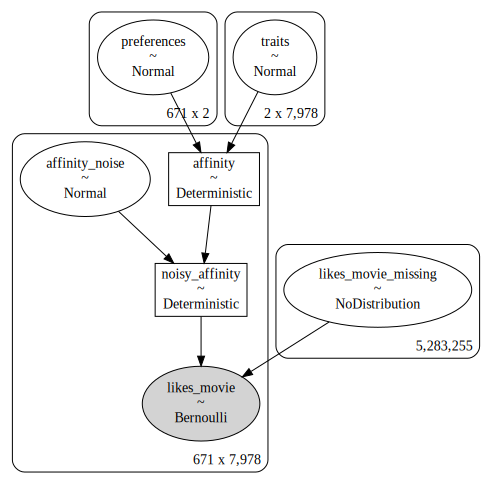

In [45]:
pm.model_to_graphviz(model)

In [46]:
#with model:
#    trace = pm.sample(1000, return_inferencedata=True, cores=1)

The sampler fails. +PyMC imputes missing values in the matrimx, which is not what we want. The research shows that I need to rely on PyMC indexing and reshape the data into a long format.

https://discourse.pymc.io/t/ignoring-missing-data-or-allowing-posterior-check-on-densitydist/10399 <- reshape into the long format, ragged arrays


https://discourse.pymc.io/t/disabling-missing-data-imputation/4926/5

https://discourse.pymc.io/t/handling-missing-data-in-linear-regression-on-timeseries-data/5364

https://discourse.pymc.io/t/sparse-array-glm-fit-in-pymc3-very-long-with-nuts/6063/6


https://discourse.pymc.io/t/missing-values-in-a-model/2157/12

These 2 tutorials show how:

https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-hierarchical.html

https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-negative-binomial-regression.html

# TO DO:

1. Reshape data to avoid missing values
2. Introduce individual thresholds / biases


## 1. Reshape data to avoid missing values

In [47]:
df_ratings.user_id.nunique(), df_ratings.user_id.min(), df_ratings.user_id.max()

(671, 1, 671)

In [48]:
df_ratings.movie_id.nunique(), df_ratings.movie_id.min(), df_ratings.movie_id.max()

(9047, 1, 163949)

In [49]:
df_train = df_ratings.loc[idx_train].reset_index().rename(columns={'index': 'orig_index'})
df_valid = df_ratings.loc[idx_valid].reset_index().rename(columns={'index': 'orig_index'})

In [50]:
df_train.user_id.nunique(), df_ratings.user_id.nunique()

(671, 671)

Following https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-hierarchical.html

In [51]:
pd.factorize(df_train.user_id)

(array([  0,   0,   0, ..., 670, 670, 670]),
 Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
             ...
             662, 663, 664, 665, 666, 667, 668, 669, 670, 671],
            dtype='int64', length=671))

In [52]:
user_idxs, users = pd.factorize(df_train.user_id)
movie_idxs, movies = pd.factorize(df_train.movie_id)

coords = {
    "movies": movies,
    "users": users,
    "obs_id": np.arange(len(movie_idxs))
}
assert len(movie_idxs) == len(user_idxs) == len(df_train)

In [53]:
coords

{'movies': Int64Index([    31,   1061,   1953,   2968,   1343,   1293,   1405,   1129,
               2150,   2294,
             ...
             134246, 134528,  89030,  72380,  60832,  64997,  55094,   3824,
               4736,   3964],
            dtype='int64', length=7978),
 'users': Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
             ...
             662, 663, 664, 665, 666, 667, 668, 669, 670, 671],
            dtype='int64', length=671),
 'obs_id': array([    0,     1,     2, ..., 69980, 69981, 69982])}

https://discourse.pymc.io/t/multi-multilevel-modeling/7514

In [54]:
preferences = np.random.normal(loc=0, scale=1/np.sqrt(2), size=(df_train.user_id.nunique(), 2))
traits = np.random.normal(loc=0, scale=1/np.sqrt(2), size=(2, df_train.movie_id.nunique()))
affinity =  tt.dot(preferences, traits)

In [55]:
affinity[user_idxs[:5], movie_idxs[:5]].eval()

array([ 0.20474474, -0.31798927,  0.87291212,  0.08884573,  0.07051364])

In [56]:
movie_idxs

array([  0,   1,   2, ..., 975, 254, 168])

In [57]:
user_idxs

array([  0,   0,   0, ..., 670, 670, 670])

In [58]:
user_idxs

array([  0,   0,   0, ..., 670, 670, 670])

In [59]:
preferences[user_idxs].shape

(69983, 2)

In [60]:
traits[:, movie_idxs].shape

(2, 69983)

In [61]:
preferences[user_idxs]

array([[-0.01154003, -0.58675701],
       [-0.01154003, -0.58675701],
       [-0.01154003, -0.58675701],
       ...,
       [ 1.307142  , -0.46817786],
       [ 1.307142  , -0.46817786],
       [ 1.307142  , -0.46817786]])

In [62]:
len(movie_idxs)

69983

In [63]:
affinity[user_idxs[:10], movie_idxs[:10]].shape.eval()

array([10])

In [64]:
affinity.eval().shape

(671, 7978)

In [65]:
affinity[user_idxs[:5], movie_idxs[:5]].eval()

array([ 0.20474474, -0.31798927,  0.87291212,  0.08884573,  0.07051364])

In [66]:
affinity[0, 0].eval()

array(0.20474474)

In [67]:
affinity[0, 1].eval()

array(-0.31798927)

In [68]:
affinity[0, 2].eval()

array(0.87291212)

In [69]:
user_idxs[:5]

array([0, 0, 0, 0, 0])

In [70]:
movie_idxs[:5]

array([0, 1, 2, 3, 4])

In [71]:
df_train[:5]

orig_index  user_id  movie_id  movie_rating  binary_rating
0           0        1        31             5              0
1           2        1      1061             6              1
2          12        1      1953             8              1
3          18        1      2968             2              0
4           9        1      1343             4              0

In [72]:
users[user_idxs[:5]]

Int64Index([1, 1, 1, 1, 1], dtype='int64')

In [73]:
movies[movie_idxs[:5]]

Int64Index([31, 1061, 1953, 2968, 1343], dtype='int64')

In [74]:
def construct_model(train_data: pd.DataFrame, n_traits: int):
    """
    Parameters
    
    ----------
    train_data: matrix with binary or missing variables of shape: people x movies
    n_traits: how many traits does a movie have
    """

    user_idxs, users = pd.factorize(train_data.user_id)
    movie_idxs, movies = pd.factorize(train_data.movie_id)

    coords = {
        "movies": movies,
        "users": users,
        "obs_id": np.arange(len(movie_idxs)),
        "traits": np.arange(n_traits)
    }
    assert len(movie_idxs) == len(user_idxs) == len(train_data)


    with pm.Model(coords=coords) as model:
        
        user_idx = pm.Data("user_idx", user_idxs, dims="obs_id")
        movie_idx = pm.Data("movie_idx", movie_idxs, dims="obs_id")
        binary_rating = pm.Data("binary_rating", train_data.binary_rating, dims="obs_id")

        user_preferences = pm.Normal('user_preferences', mu=0, sigma=1 / np.sqrt(n_traits), dims=('users', 'traits'))
        movie_traits = pm.Normal('movie_traits', mu=0, sigma= 1/ np.sqrt(n_traits), dims=('traits', 'movies'))

        affinity = pm.Deterministic('affinity', tt.dot(user_preferences, movie_traits), dims=('users', 'movies'))
        affinity_noise = pm.Normal('affinity_noise', mu=0, sigma=1, dims=('users', 'movies'))

        noisy_affinity = pm.Deterministic('noisy_affinity', affinity + affinity_noise, dims=('users', 'movies'))
        noisy_affinity_long = pm.Deterministic('noisy_affinity_long', pm.invprobit(noisy_affinity[user_idxs, movie_idxs]), dims='obs_id')

        likes_movie = pm.Bernoulli('likes_movie', noisy_affinity_long, observed=binary_rating,  dims='obs_id')
    return model

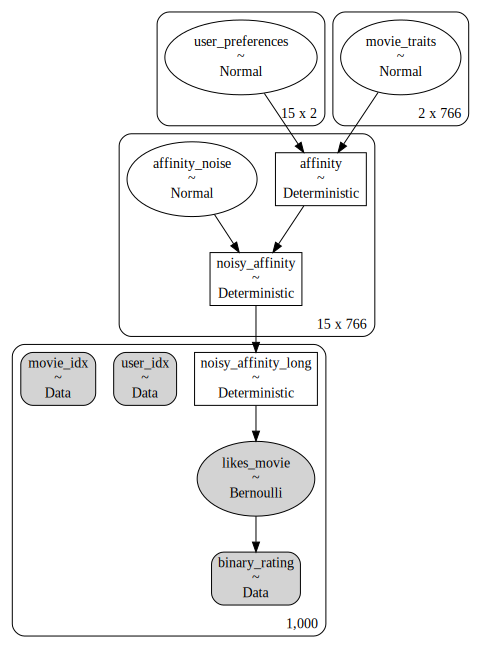

In [75]:
model = construct_model(df_train[:1000], n_traits=2)
pm.model_to_graphviz(model)

In [76]:
with model:
    trace = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
ERROR (theano.graph.opt): Optimization failure due to: local_grad_log_erfc_neg
ERROR (theano.graph.opt): node: Elemwise{true_div,no_inplace}(Elemwise{mul,no_inplace}.0, Elemwise{erfc,no_inplace}.0)
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/amosin/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/theano/graph/opt.py", line 2017, in process_node
    replacements = lopt.transform(fgraph, node)
  File "/Users/amosin/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/theano/graph/opt.py", line 1209, in transform
    return self.fn(*args, **kwargs)
  File "/Users/amosin/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/theano/tensor/opt.py", line 7291, in local_grad_log_erfc_neg
    if not exp_in.owner.inputs[0].owner:
AttributeError: 'NoneType' object has no attribute 'owner'

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 154 seconds.
The acceptance probability does not match the target. It is 0.7078506164984628, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7147266170655794, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6882081874519531, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [77]:
len(df_train)

69983

In [78]:
df_train.user_id.nunique()

671

In [79]:
trace.posterior['user_preferences'].mean(axis=0).shape

(1000, 15, 2)

In [80]:
trace.posterior['movie_traits'].mean(axis=0).shape

(1000, 2, 766)

In [82]:
trace.posterior.users[trace.constant_data.user_idx]

<xarray.DataArray 'users' (obs_id: 1000)>
array([ 1,  1,  1, ..., 15, 15, 15])
Coordinates:
    users    (obs_id) int64 1 1 1 1 1 1 1 1 1 1 ... 15 15 15 15 15 15 15 15 15
  * obs_id   (obs_id) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999

In [83]:
trace.posterior.movies[trace.constant_data.movie_idx]

<xarray.DataArray 'movies' (obs_id: 1000)>
array([  31, 1061, 1953, ..., 2803,  994, 2313])
Coordinates:
    movies   (obs_id) int64 31 1061 1953 2968 1343 ... 2140 2160 2803 994 2313
  * obs_id   (obs_id) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999

In [84]:
df_train[:1000]

orig_index  user_id  movie_id  movie_rating  binary_rating
0             0        1        31             5              0
1             2        1      1061             6              1
2            12        1      1953             8              1
3            18        1      2968             2              0
4             9        1      1343             4              0
..          ...      ...       ...           ...            ...
995        1412       15      2140             6              1
996        1415       15      2160             6              1
997        1531       15      2803             3              0
998        1161       15       994             8              1
999        1437       15      2313             7              1

[1000 rows x 5 columns]

In [85]:
trace.posterior['user_preferences'].mean(axis=0).shape

(1000, 15, 2)

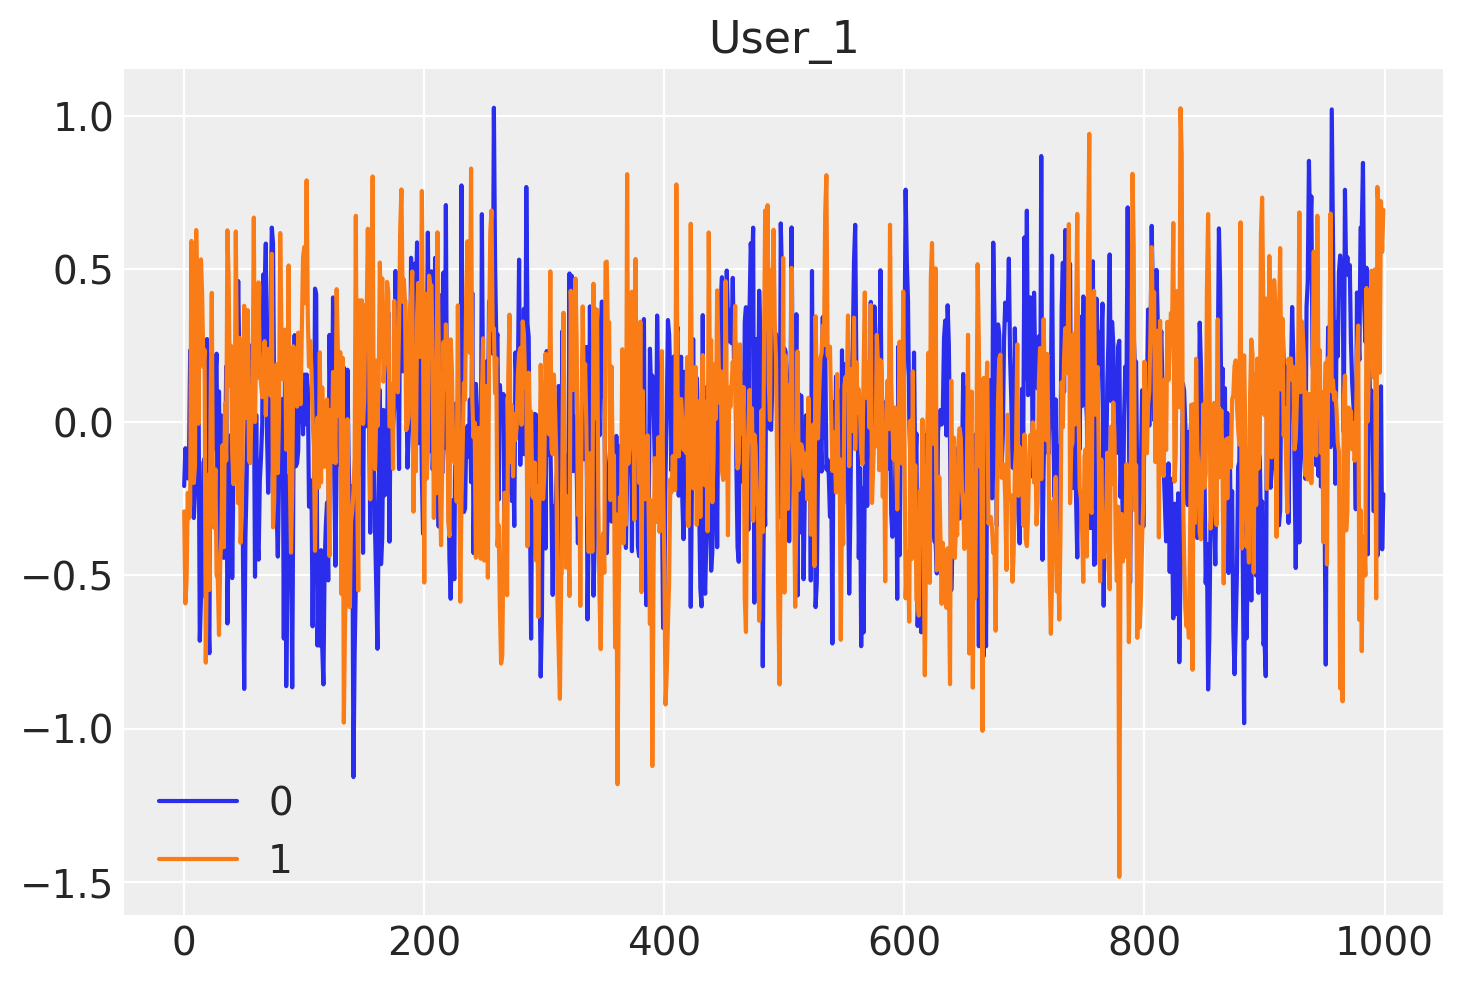

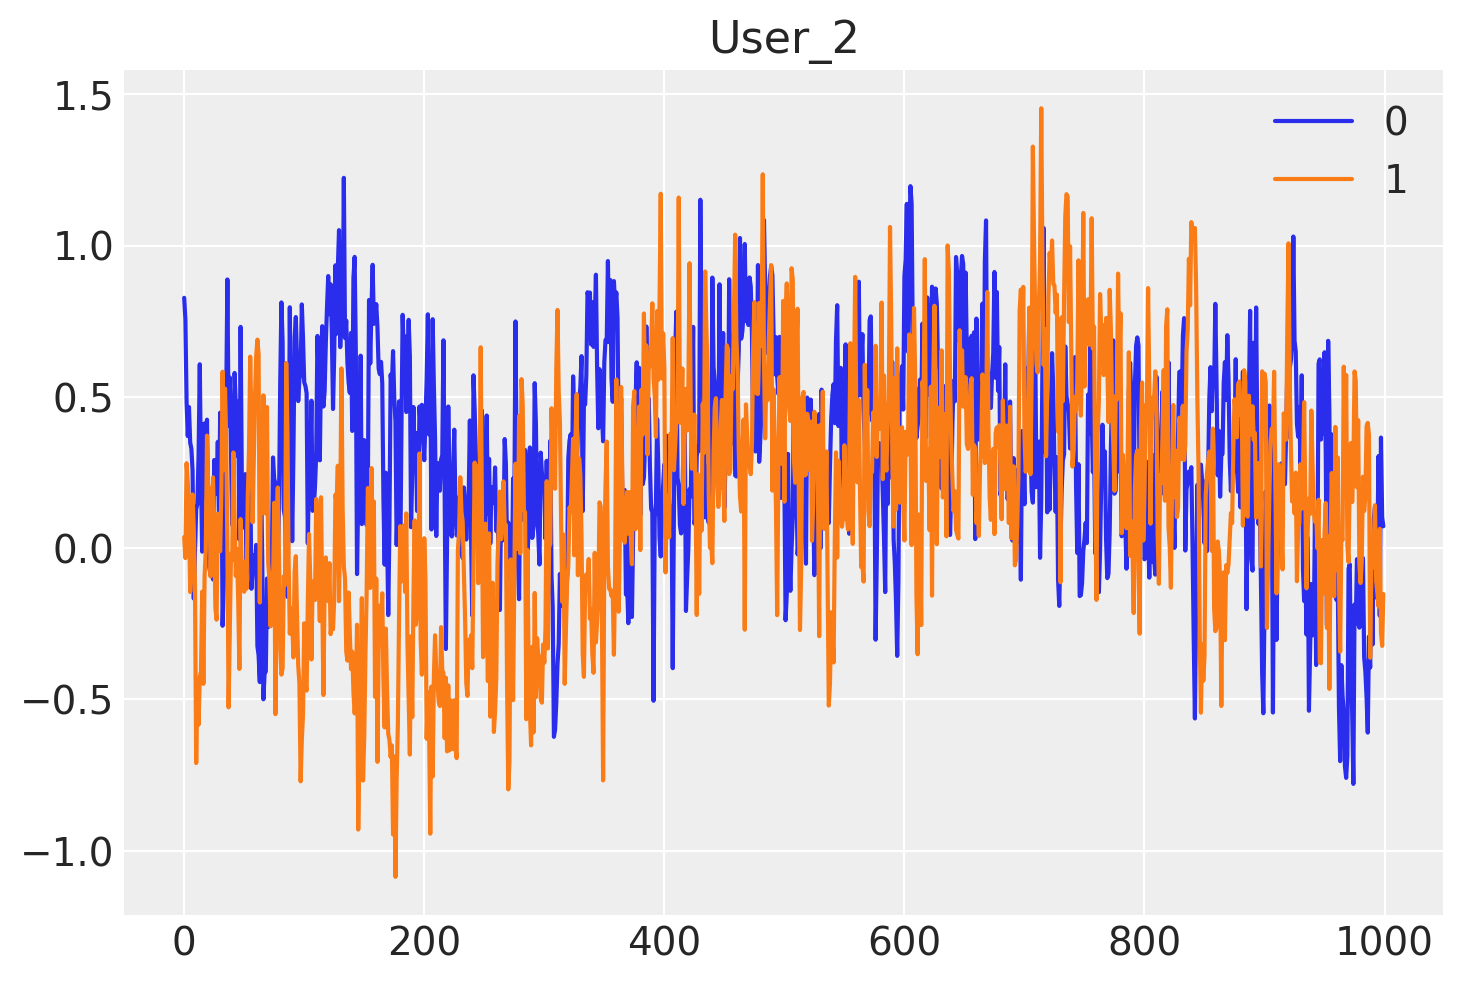

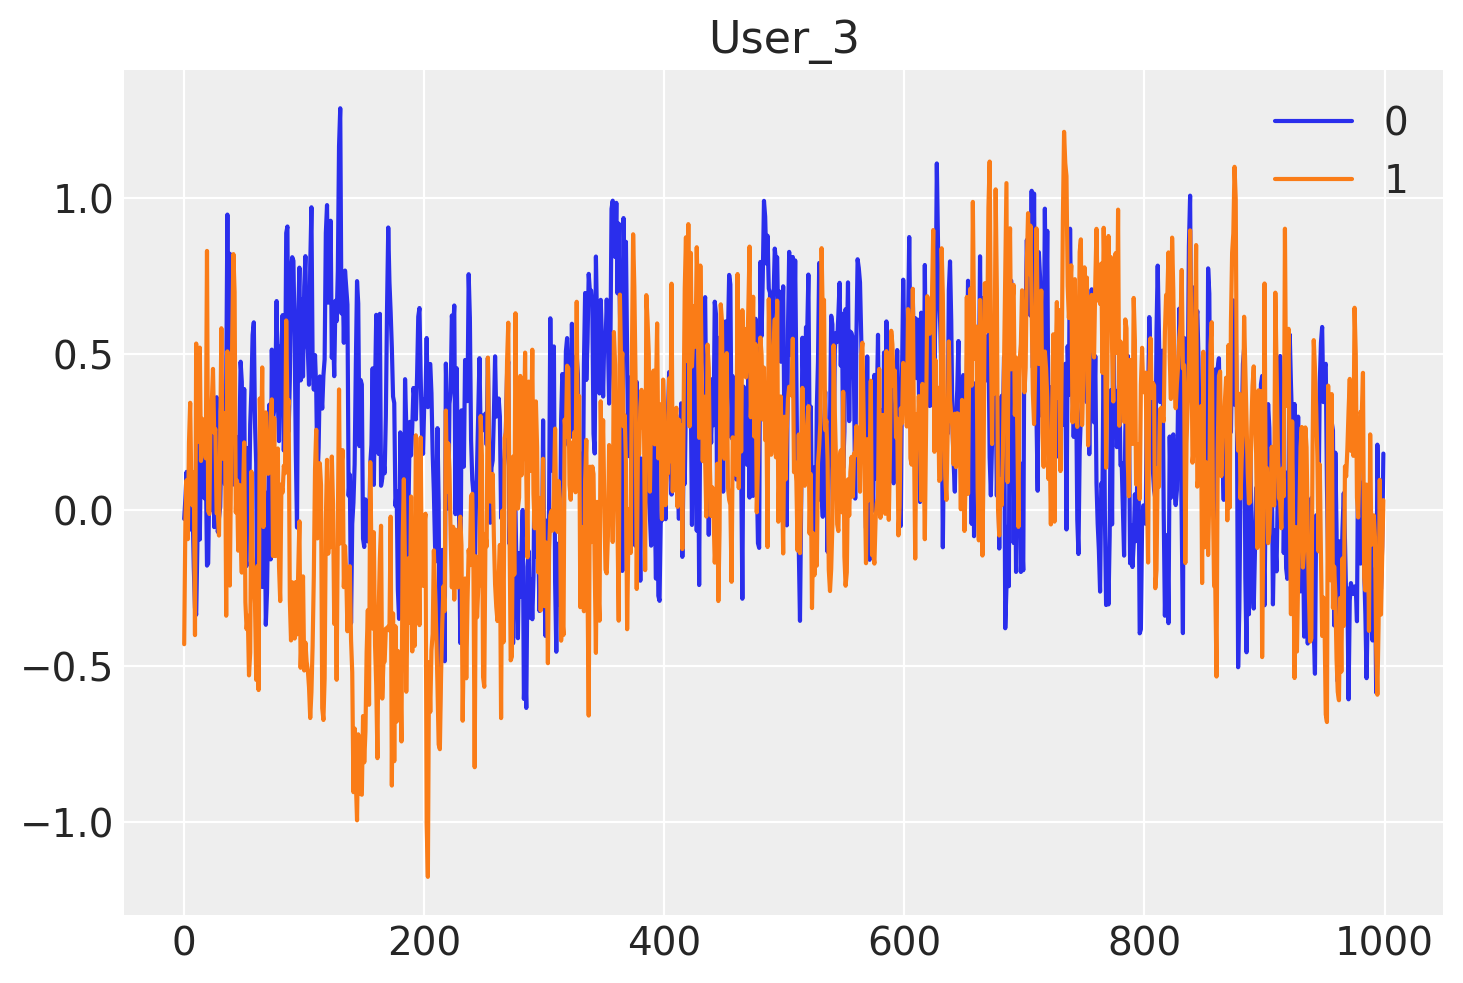

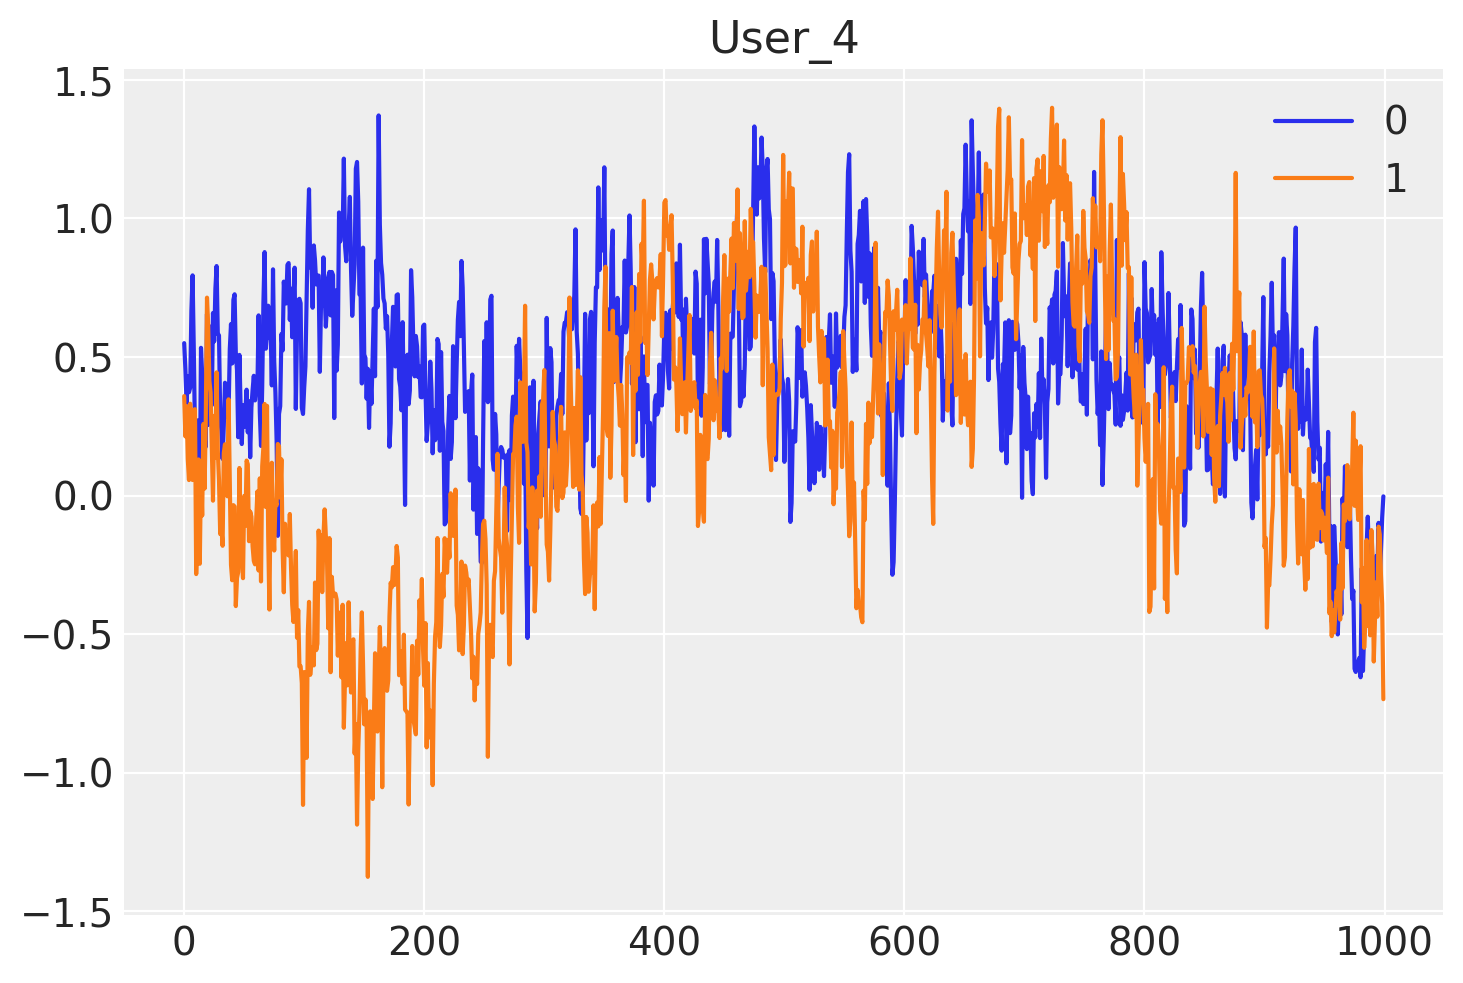

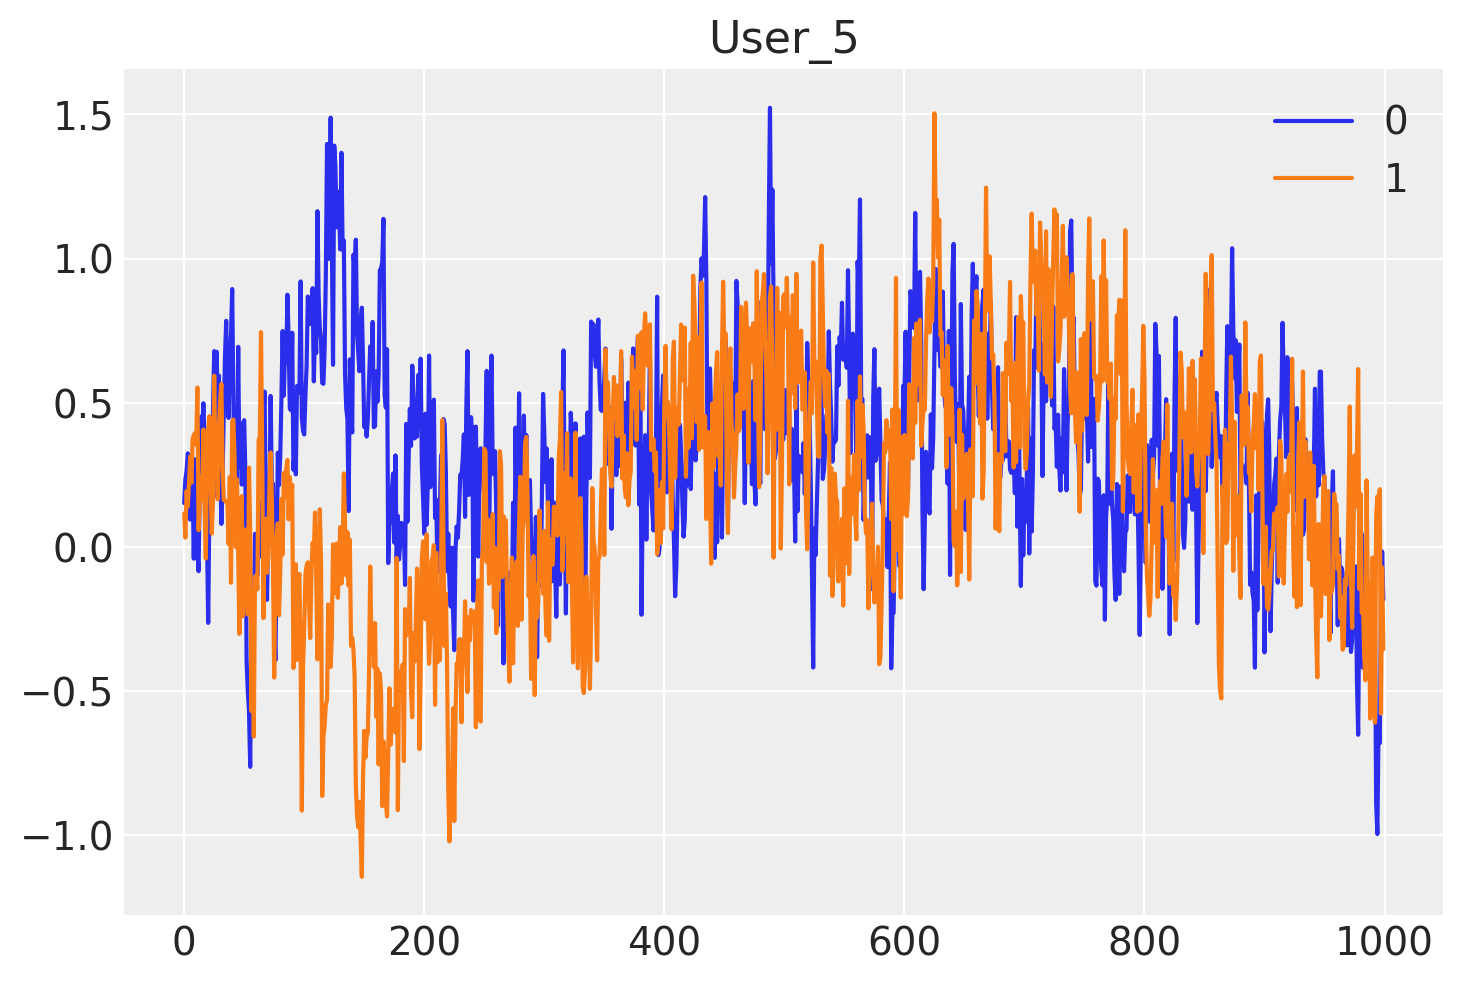

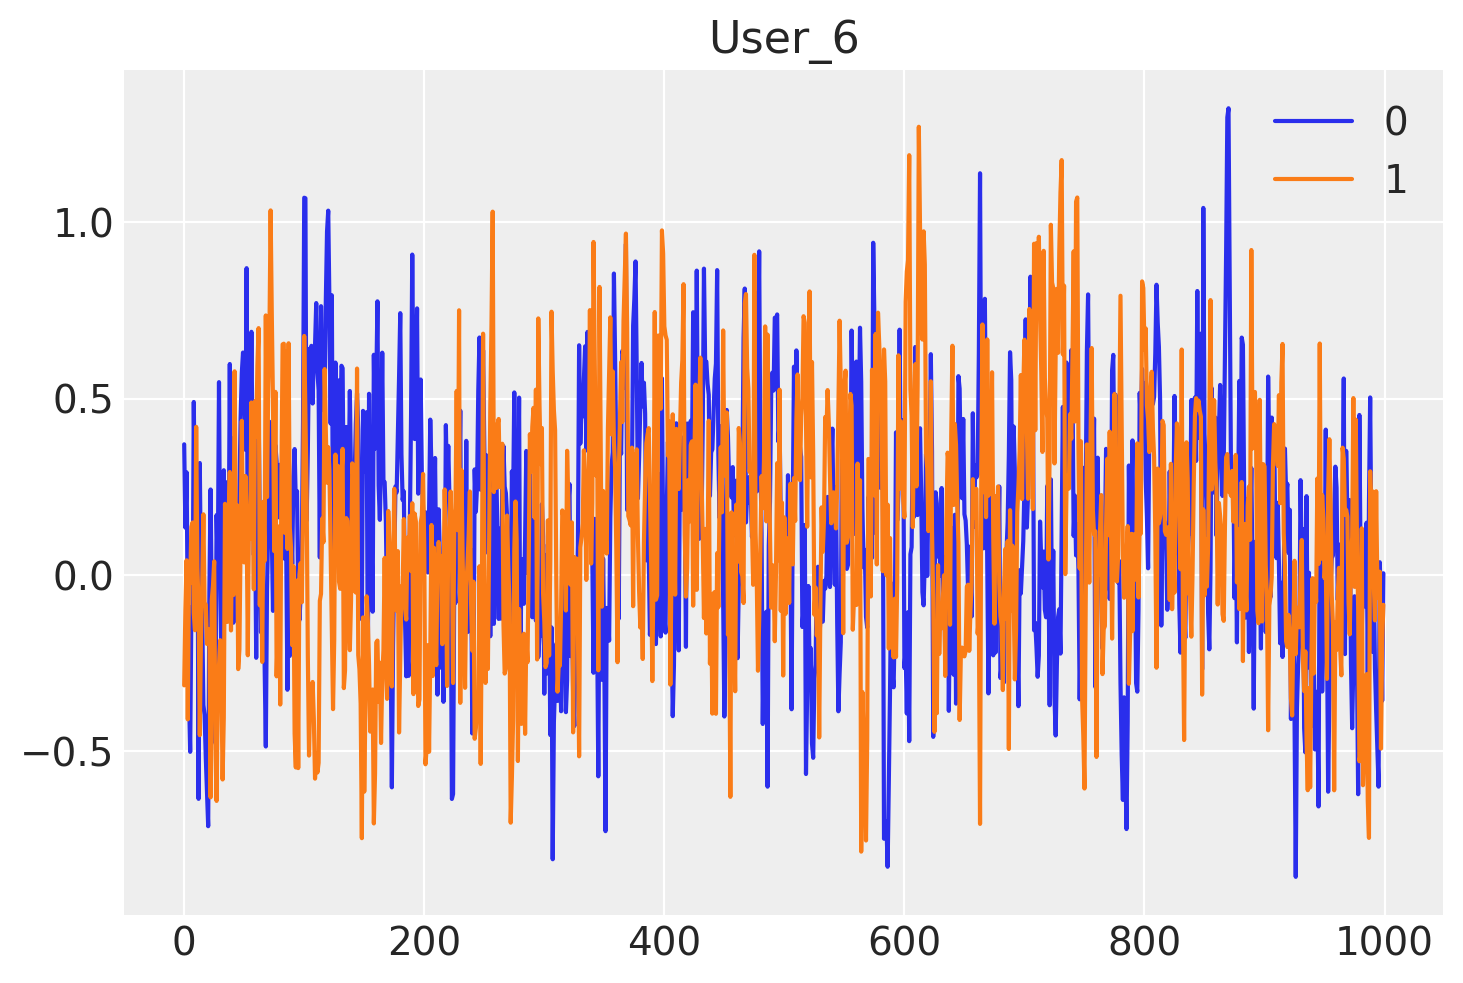

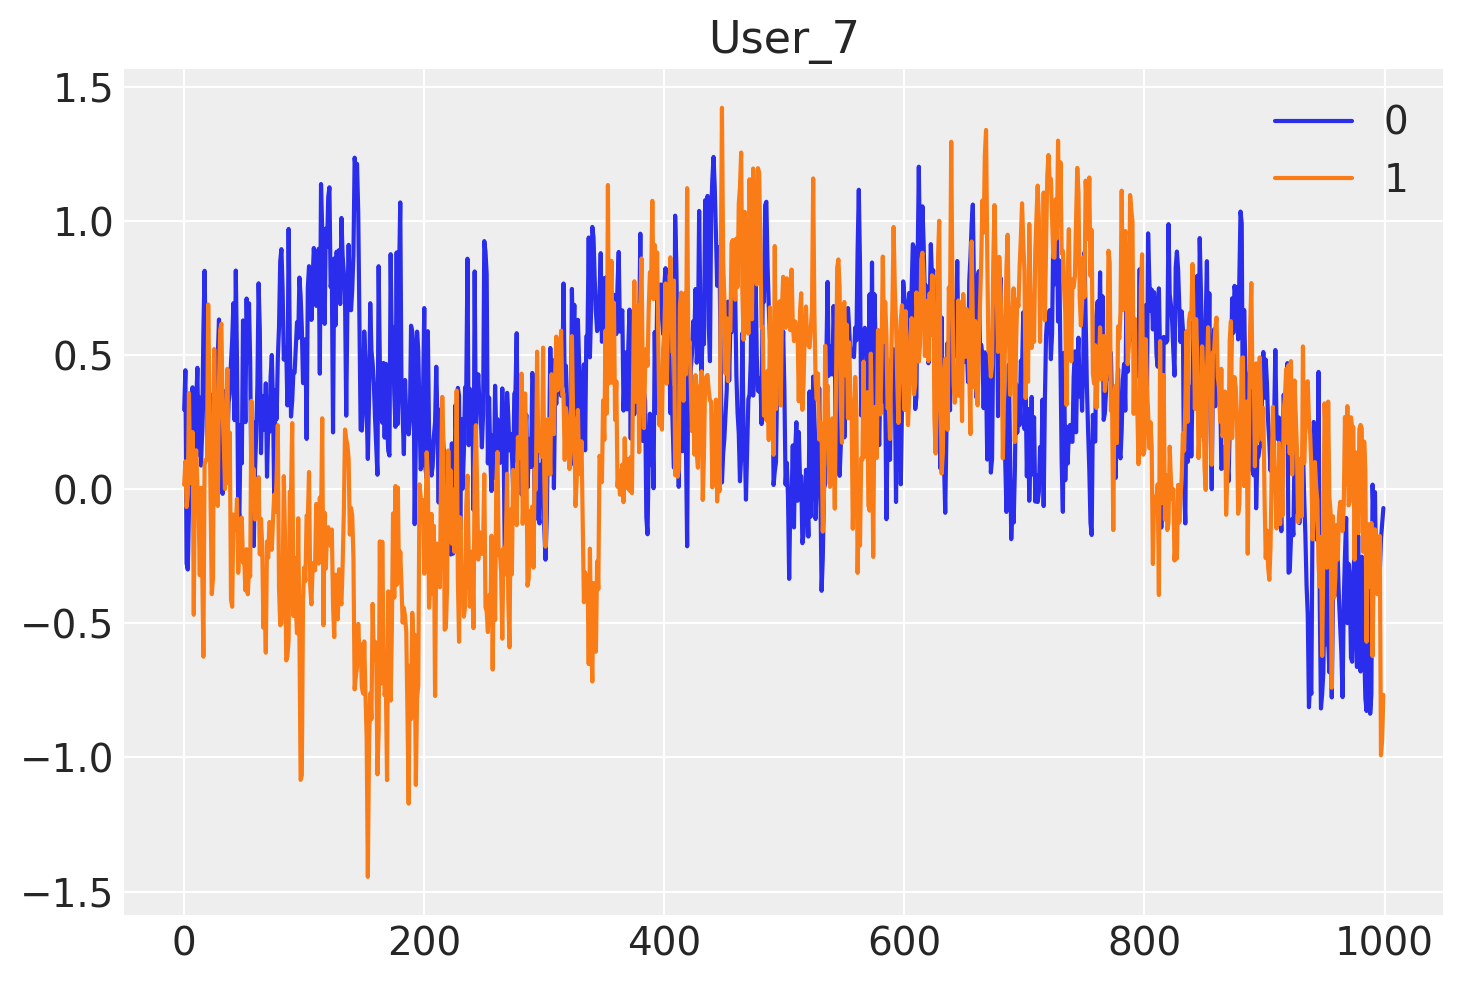

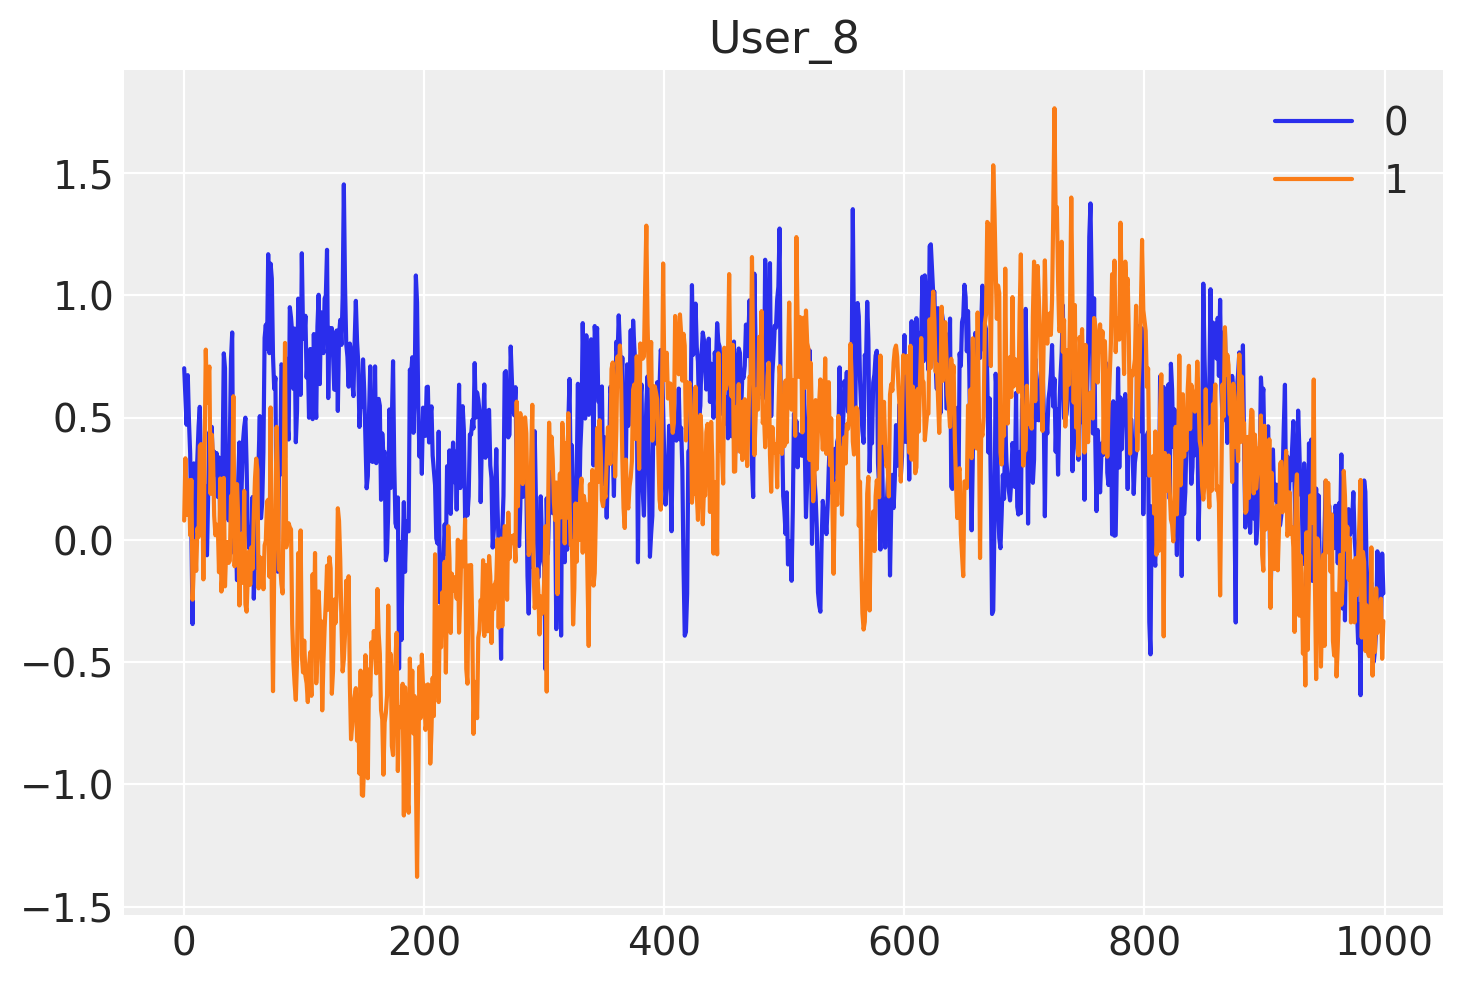

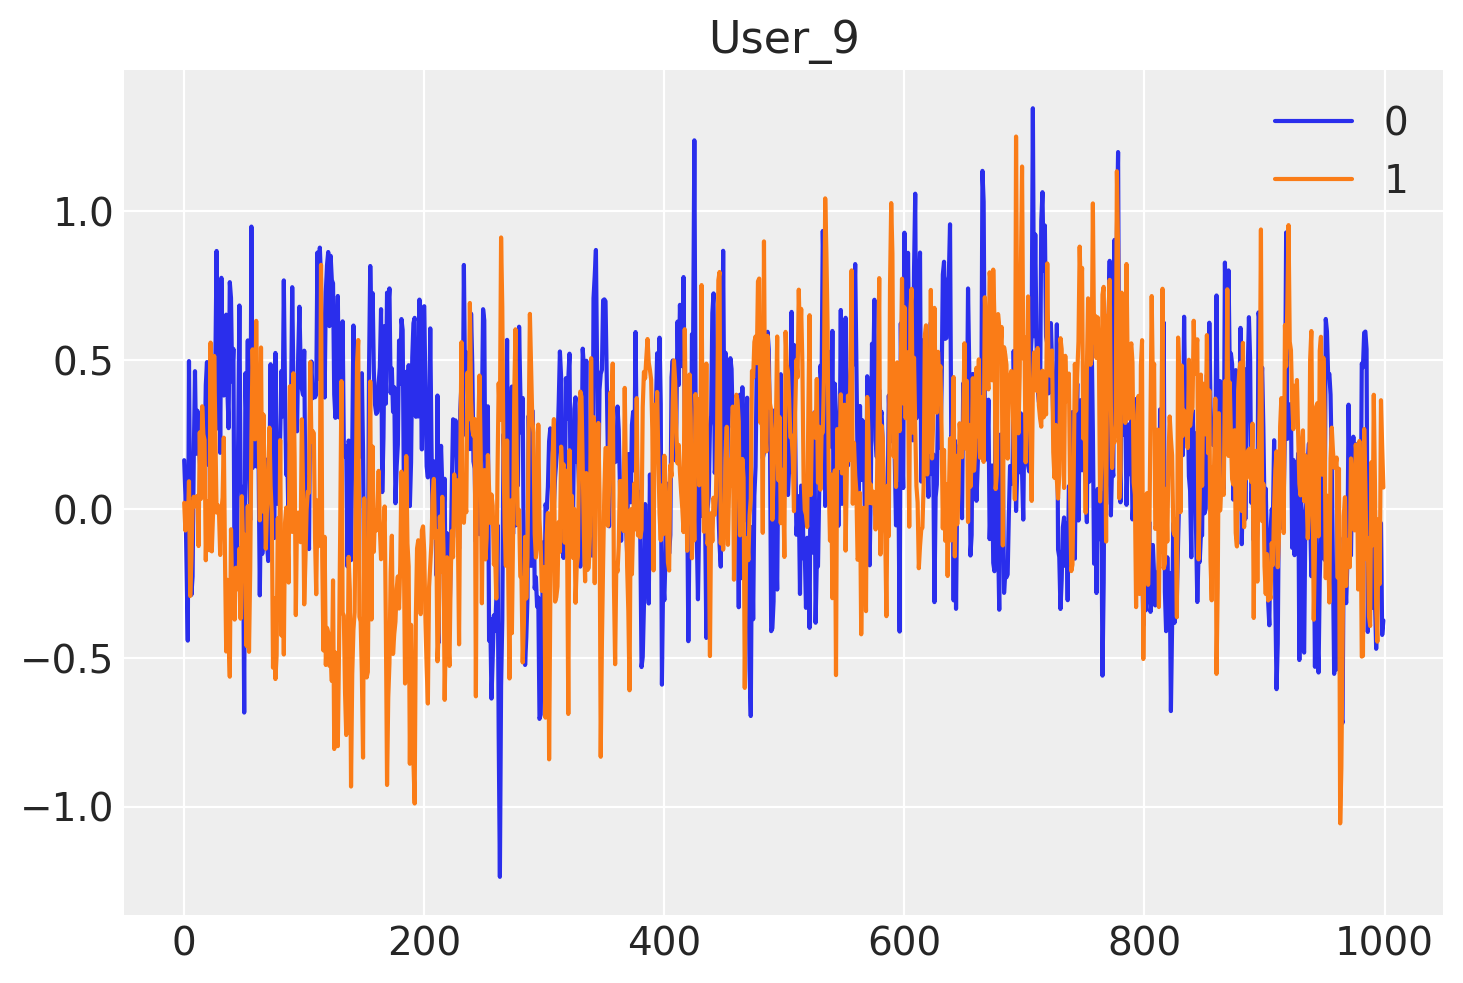

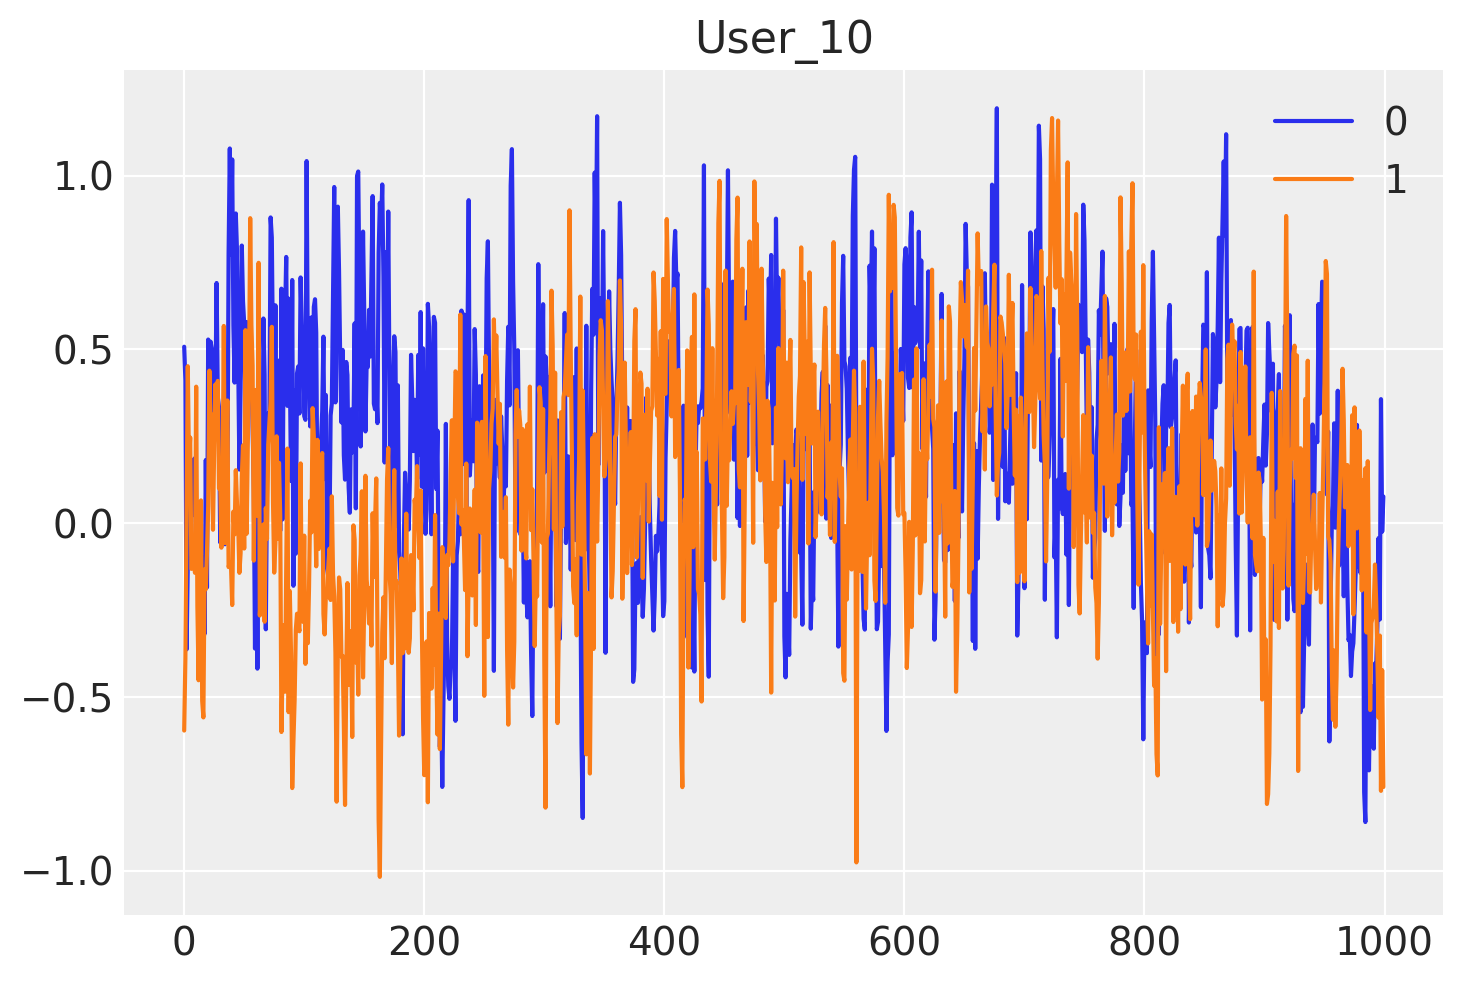

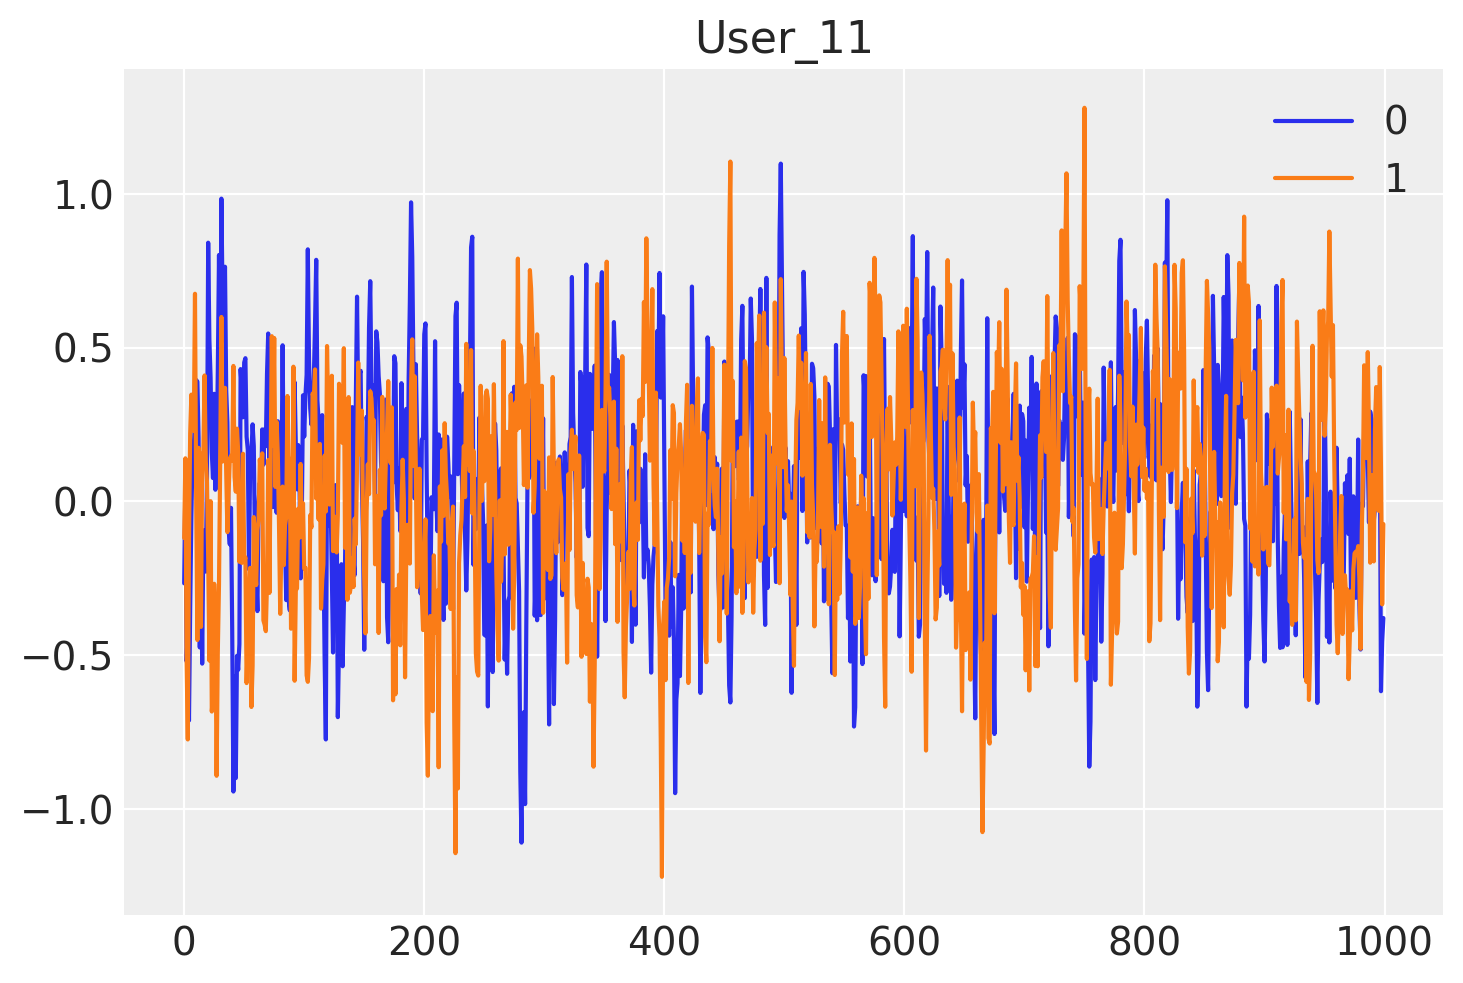

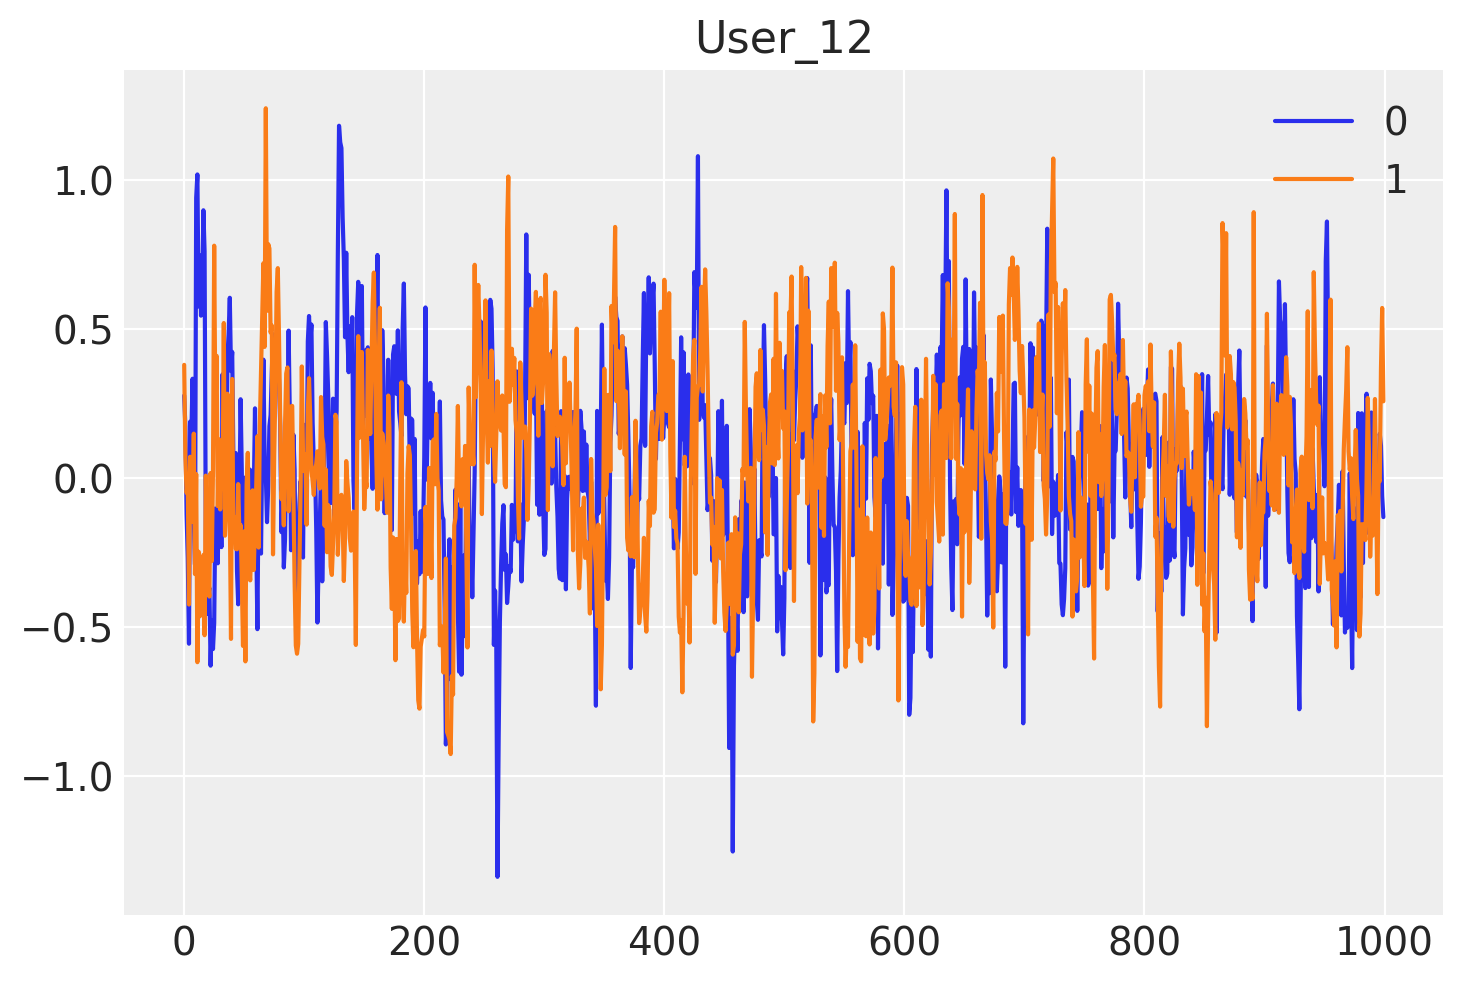

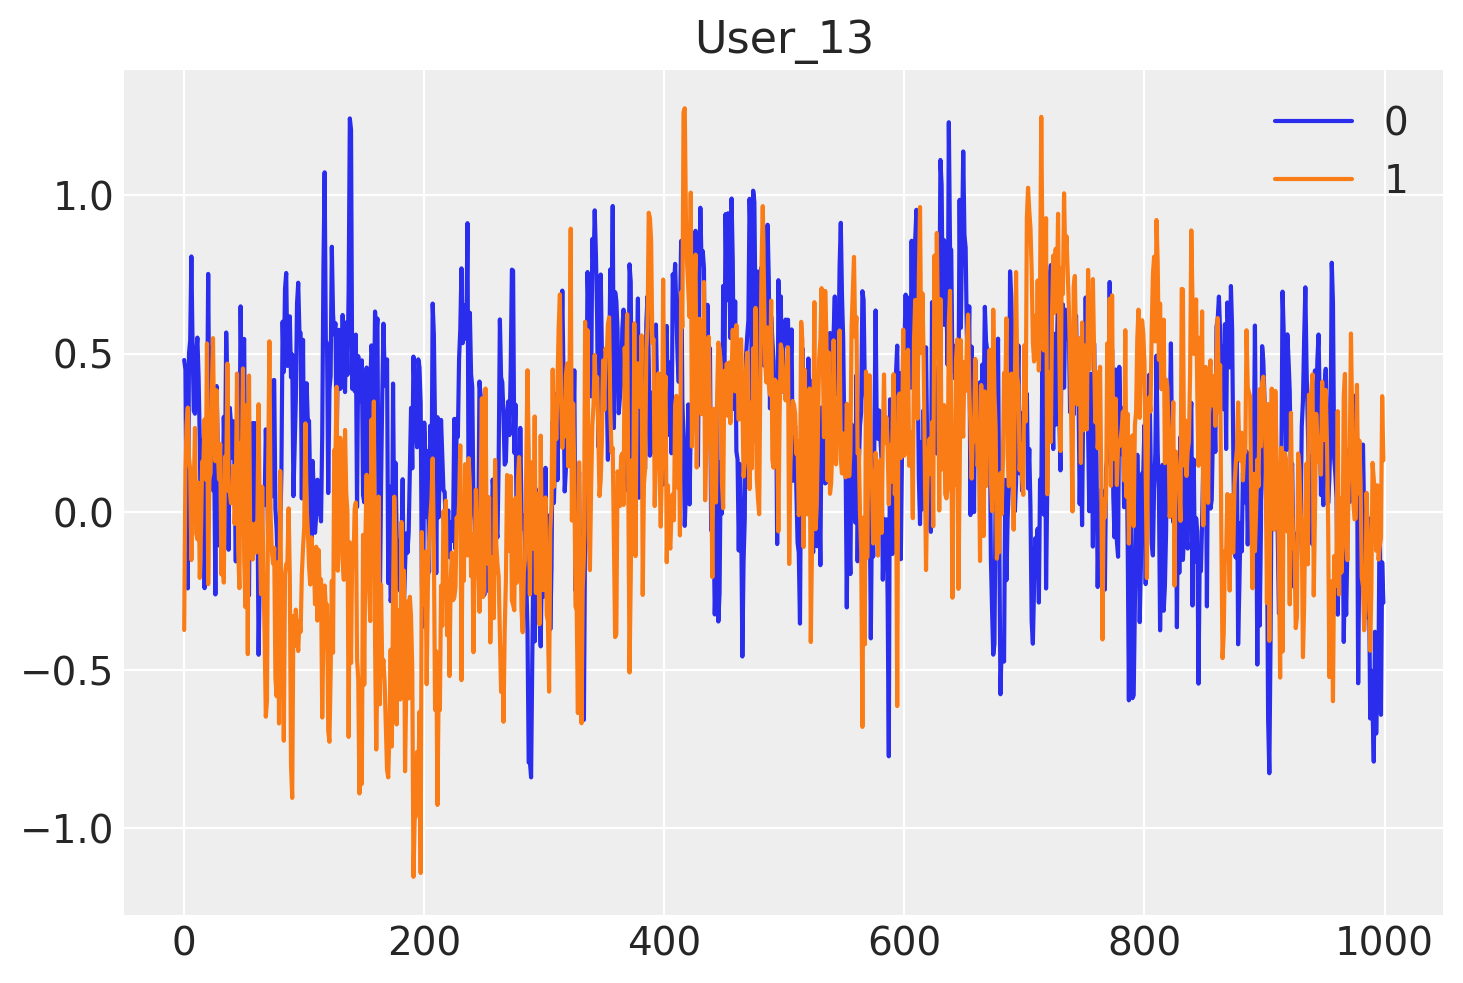

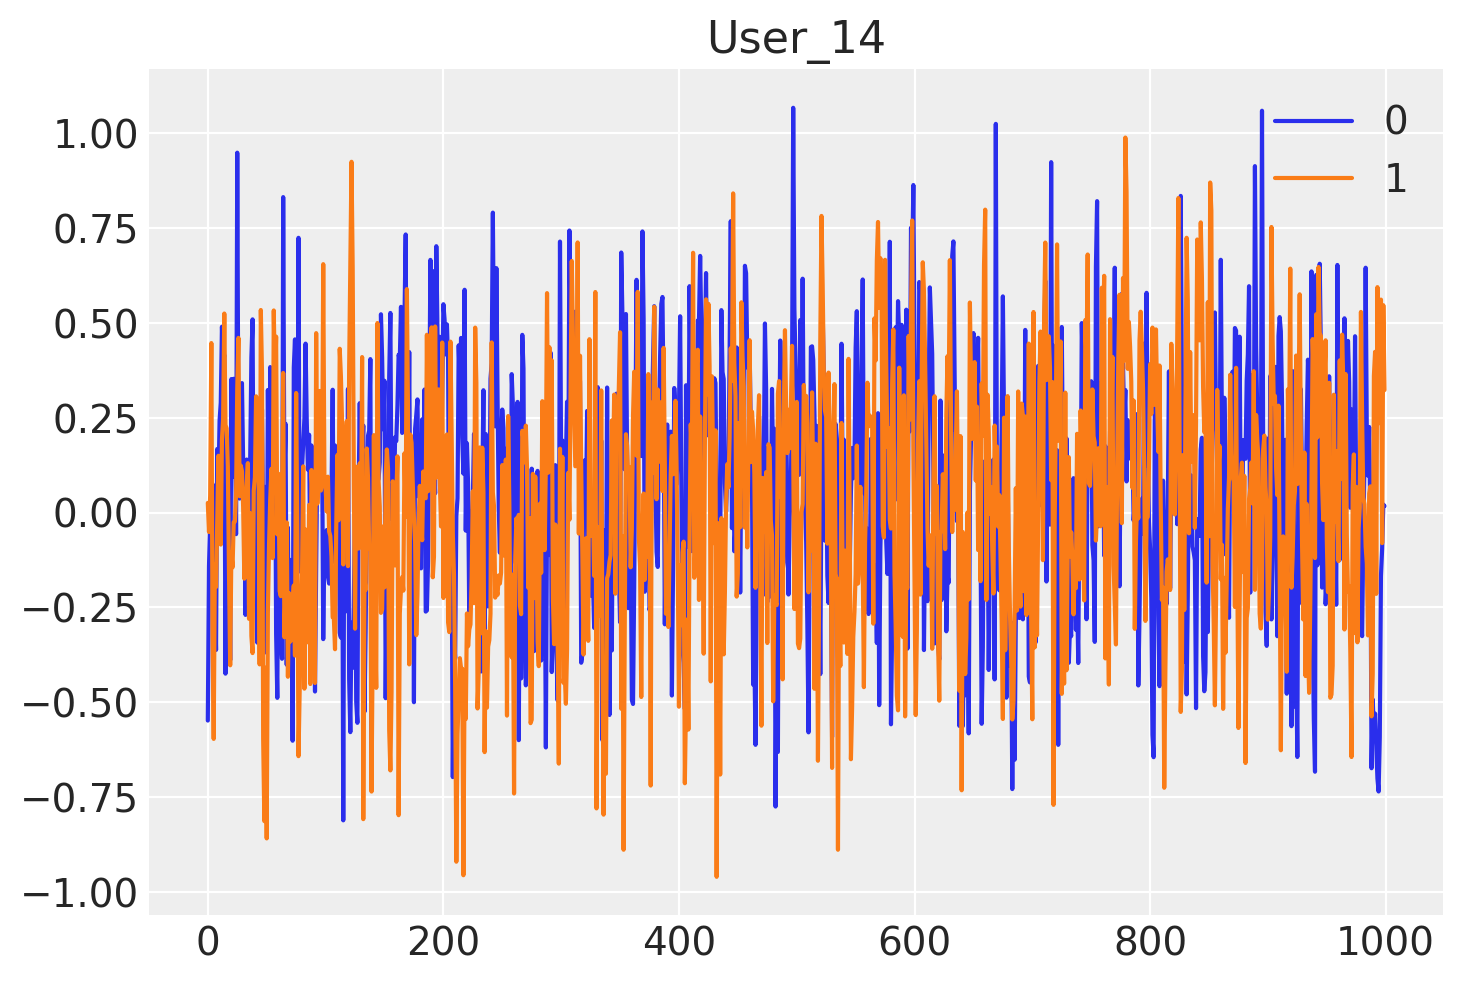

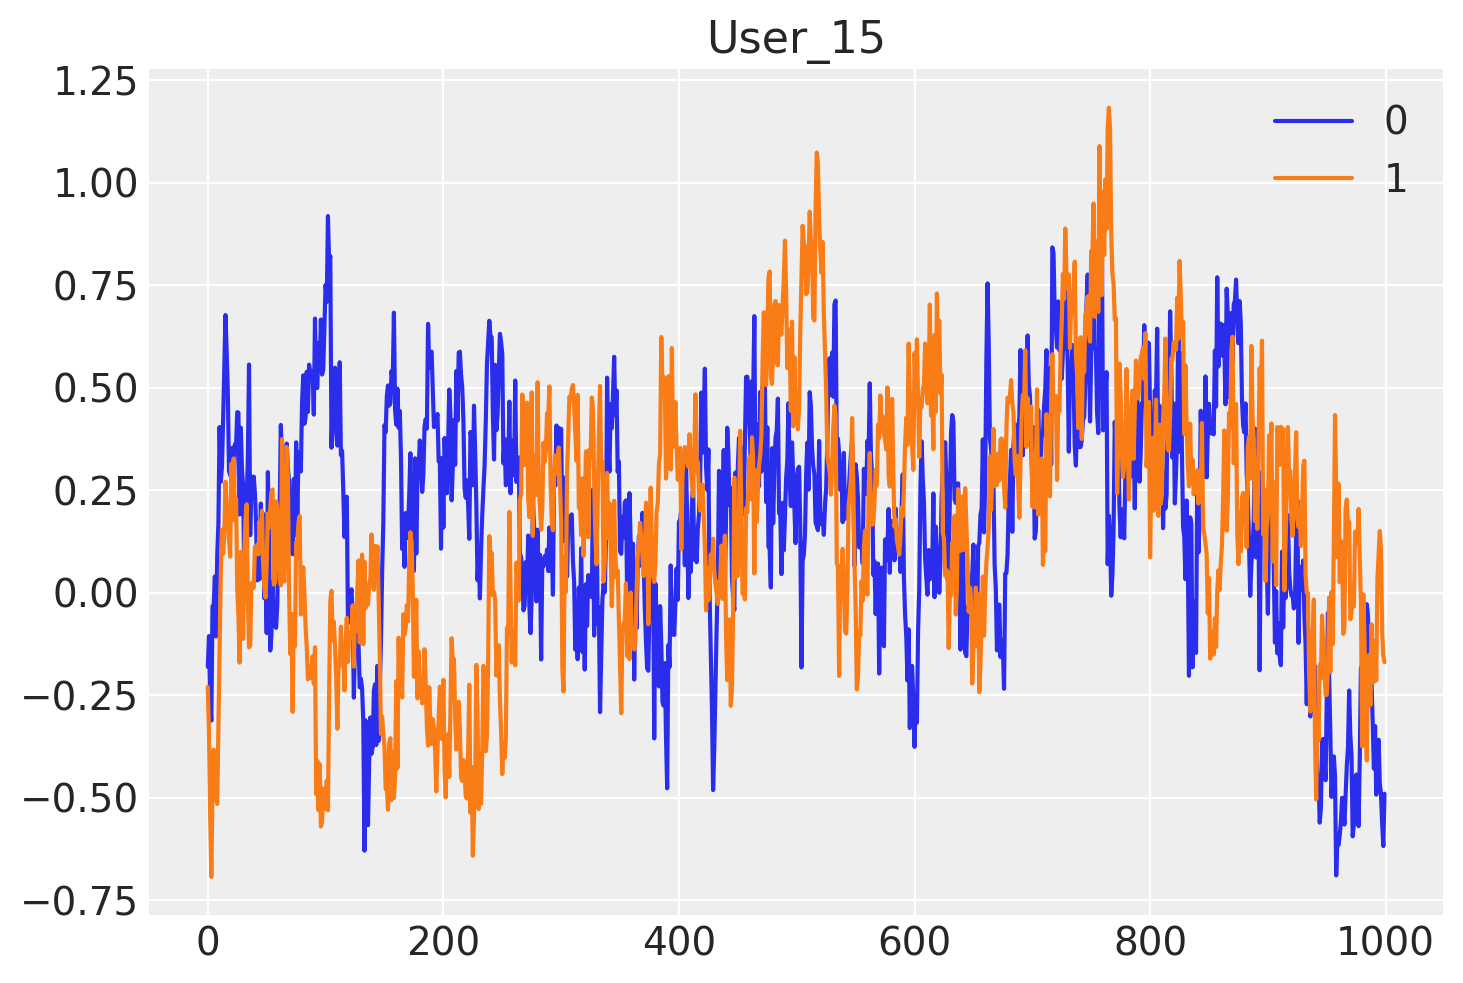

In [87]:
for u in range(df_train[:1000].user_id.nunique()):
    pd.DataFrame(trace.posterior['user_preferences'].mean(axis=0)[:, u, :]).plot()
    plt.title(f"User_{trace.posterior.users[u].item()}")

#### User traits are are highly correated across samples. To fix it, I need to break symmetry.

## 2. Break the symmetry 

https://docs.pymc.io/en/v3/pymc-examples/examples/mixture_models/gaussian_mixture_model.html

https://discourse.pymc.io/t/why-does-transform-pm-distributions-transforms-ordered-lead-to-worse-convergence/7944

https://discourse.pymc.io/t/two-different-ways-to-write-a-mixture-model-question-about-pm-normalmixture/2688

https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/factor_analysis.html <- constrain the form of the matrix

In [72]:
preferences.shape

(671, 2)

    To solve this inference problem, we need to do some kind of symmetry breaking. Symmetry breaking is any modification to the model or inference algorithm with the aim of removing symmetries from the posterior distributions of interest. For a two-trait version of our model, we can break symmetry by fixing the position of two points in trait space – for example, fixing the positions of the first two movies in the training set. We choose to fix the first movie to (1,0) and the second to (0,1). These two points mean that rotations and flips of the trait space now lead to different results, since these two movies cannot be rotated/flipped correspondingly – and so we have removed the symmetries from our model.

fixing 2 movies

In [89]:
traits.shape

(2, 7978)

In [90]:
np.hstack((np.zeros([2, 2]),  traits[:, 2:])).shape

(2, 7978)

In [91]:
traits[:, 2:].shape

(2, 7976)

In [92]:
traits[:, [0, 1]]

array([[ 0.34300087, -0.103412  ],
       [-0.35568894,  0.54397755]])

In [93]:
np.eye(2, 2).shape

(2, 2)

In [94]:
tt.concatenate([np.eye(2, 2), traits[:, 2:]], axis=1).shape.eval()

array([   2, 7978])

In [95]:
tt.concatenate([np.eye(2, 2), traits[:, 2:]], axis=1).eval()[:, :5]

array([[ 1.        ,  0.        , -0.66006891, -0.26187321, -0.34572367],
       [ 0.        ,  1.        , -1.47470738, -0.14626788, -0.11337568]])

In [96]:
def construct_model(train_data: pd.DataFrame, n_traits: int):
    """
    Parameters
    
    ----------
    train_data: matrix with binary or missing variables of shape: people x movies
    n_traits: how many traits does a movie have
    """

    user_idxs, users = pd.factorize(train_data.user_id)
    movie_idxs, movies = pd.factorize(train_data.movie_id)

    coords = {
        "movies": movies,
        "users": users,
        "obs_id": np.arange(len(movie_idxs)),
        "traits": np.arange(n_traits)
    }
    assert len(movie_idxs) == len(user_idxs) == len(train_data)


    with pm.Model(coords=coords) as model:
        
        user_idx = pm.Data("user_idx", user_idxs, dims="obs_id")
        movie_idx = pm.Data("movie_idx", movie_idxs, dims="obs_id")
        binary_rating = pm.Data("binary_rating", train_data.binary_rating, dims="obs_id")

        user_preferences = pm.Normal('user_preferences', mu=0, sigma = 1 / np.sqrt(n_traits), dims=('users', 'traits'))
        movie_traits_init = pm.Normal('movie_traits_init', mu=0, sigma =  1/ np.sqrt(n_traits), dims=('traits', 'movies'))
        
        # break symmetry by assigning first 2 movies to the base vectors [1, 0 ...], [0, 1, ...]
        movie_traits = pm.Deterministic('movie_traits', tt.concatenate([np.eye(n_traits, 2), movie_traits_init[:, 2:]], axis=1), dims=('traits', 'movies'))

        affinity = pm.Deterministic('affinity', tt.dot(user_preferences, movie_traits), dims=('users', 'movies'))
        affinity_noise = pm.Normal('affinity_noise', mu=0, sigma=1, dims=('users', 'movies'))

        noisy_affinity = pm.Deterministic('noisy_affinity', affinity + affinity_noise, dims=('users', 'movies'))
        noisy_affinity_long = pm.Deterministic('noisy_affinity_long', pm.invprobit(noisy_affinity[user_idxs, movie_idxs]), dims='obs_id')

        likes_movie = pm.Bernoulli('likes_movie', noisy_affinity_long, observed=binary_rating,  dims='obs_id')
    return model

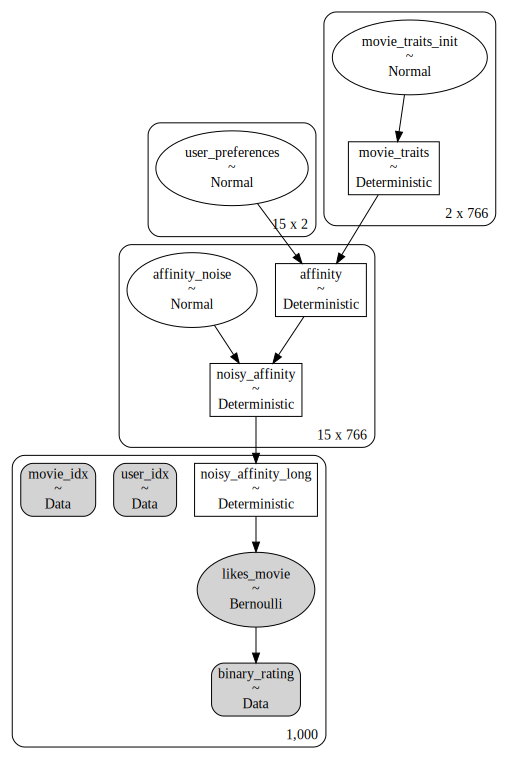

In [98]:
model = construct_model(df_train[:1000], n_traits=2)
pm.model_to_graphviz(model)

In [99]:
with model:
    trace = pm.sample(1000, tune=5000, return_inferencedata=True, random_seed=39122021)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
ERROR (theano.graph.opt): Optimization failure due to: local_grad_log_erfc_neg
ERROR (theano.graph.opt): node: Elemwise{true_div,no_inplace}(Elemwise{mul,no_inplace}.0, Elemwise{erfc,no_inplace}.0)
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/amosin/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/theano/graph/opt.py", line 2017, in process_node
    replacements = lopt.transform(fgraph, node)
  File "/Users/amosin/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/theano/graph/opt.py", line 1209, in transform
    return self.fn(*args, **kwargs)
  File "/Users/amosin/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/theano/tensor/opt.py", line 7291, in local_grad_log_erfc_neg
    if not exp_in.owner.inputs[0].owner:
AttributeError: 'NoneType' object has no attribute 'owner'

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [

Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 416 seconds.
The acceptance probability does not match the target. It is 0.6663800050704883, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5748042401306834, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6305092847414961, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6341627577412041, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


Traits for some users look less correlatd

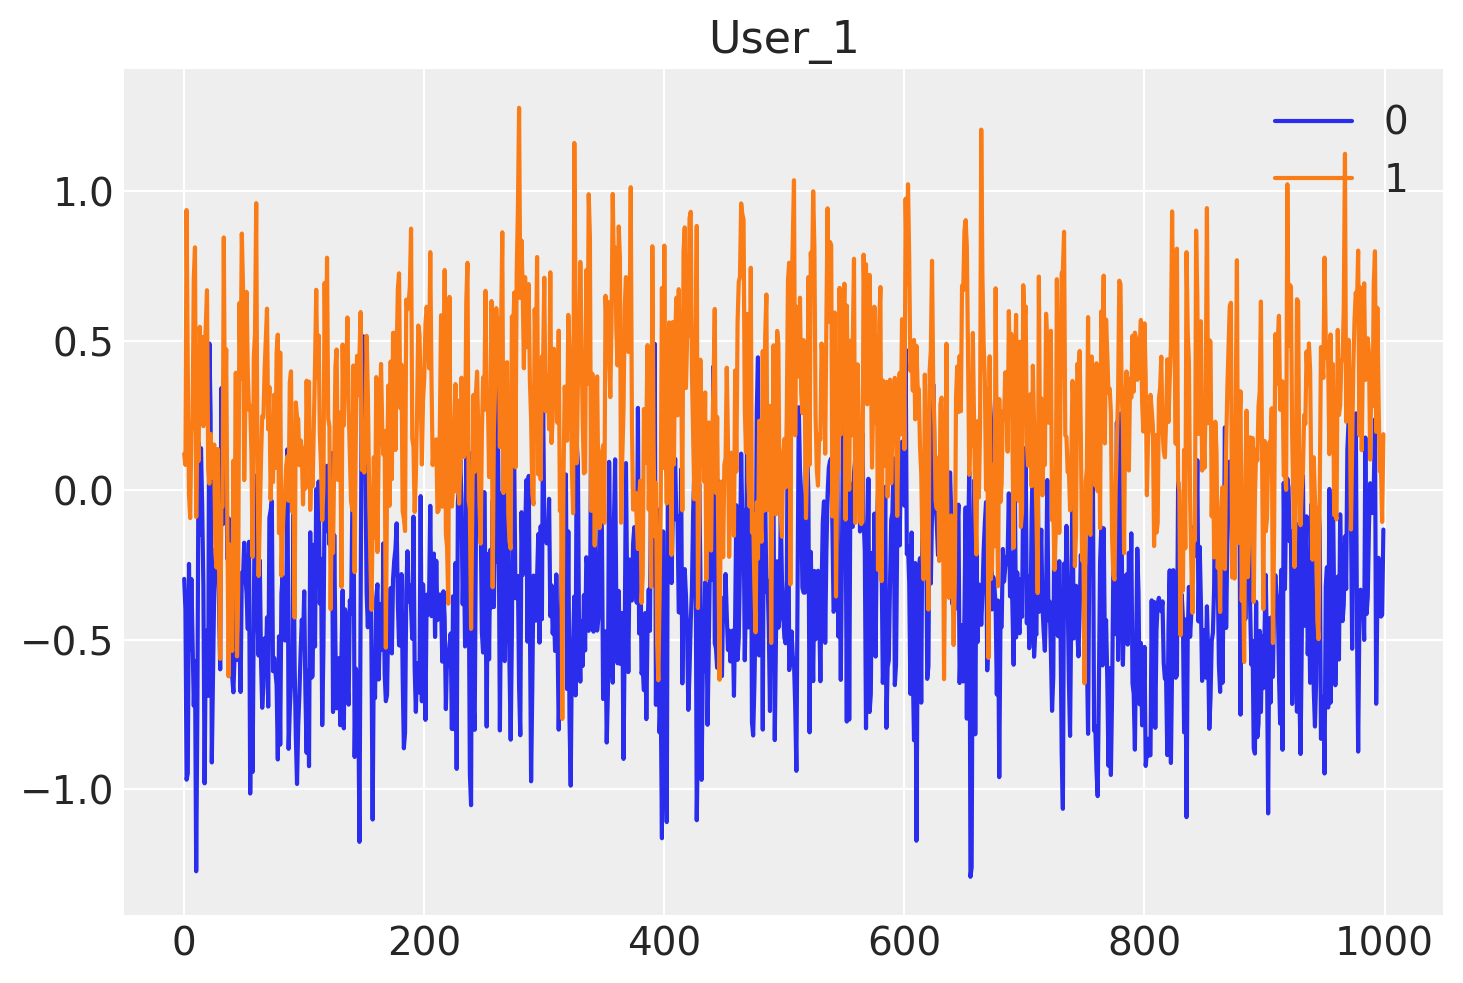

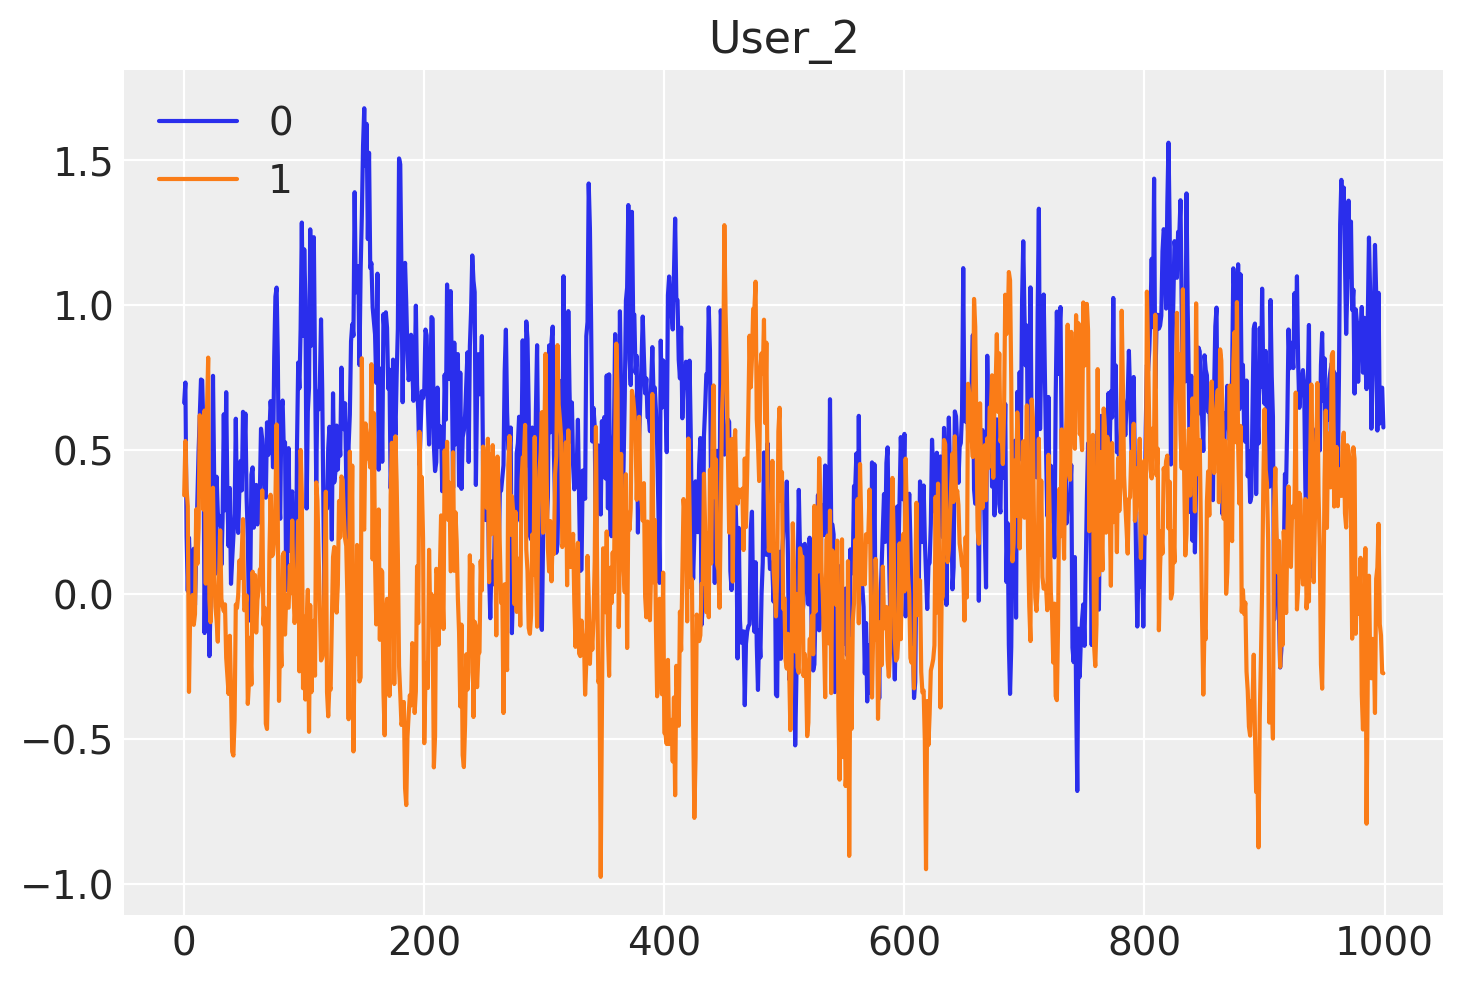

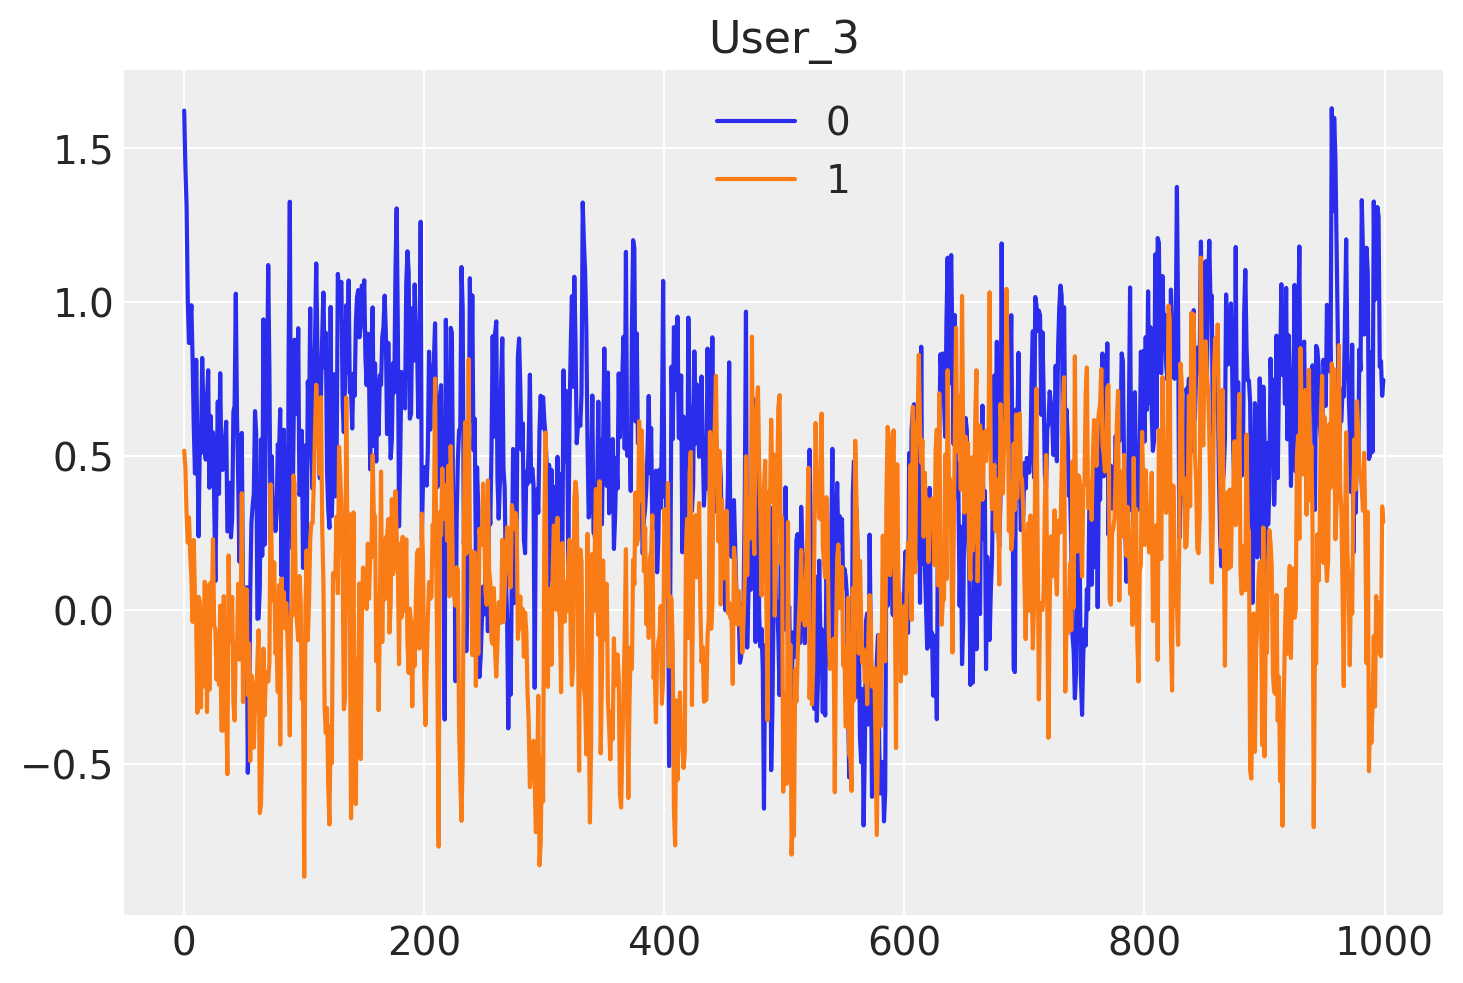

In [100]:
for u in range(df_train[:100].user_id.nunique()):
    pd.DataFrame(trace.posterior['user_preferences'].mean(axis=0)[:, u, :]).plot()
    plt.title(f"User_{trace.posterior.users[u].item()}")

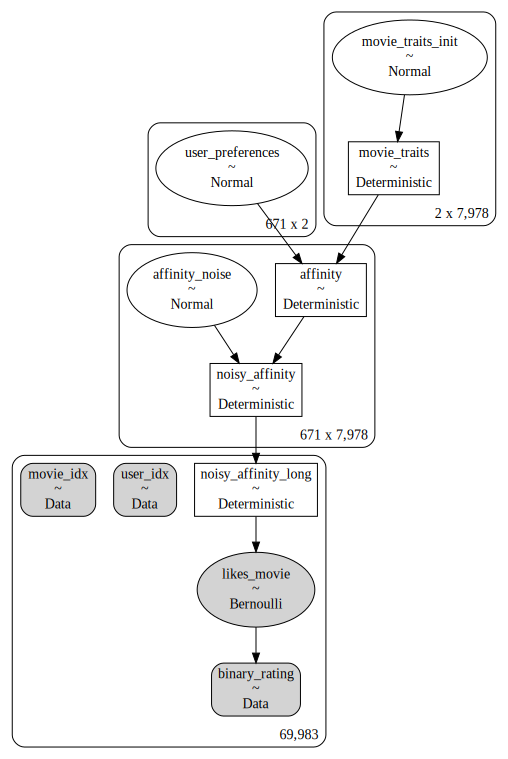

In [105]:
model = construct_model(df_train, n_traits=2)
pm.model_to_graphviz(model)

In [106]:
with model:
    trace = pm.sample(1000, tune=5000, return_inferencedata=True, random_seed=39122021)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
ERROR (theano.graph.opt): Optimization failure due to: local_grad_log_erfc_neg
ERROR (theano.graph.opt): node: Elemwise{true_div,no_inplace}(Elemwise{mul,no_inplace}.0, Elemwise{erfc,no_inplace}.0)
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/amosin/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/theano/graph/opt.py", line 2017, in process_node
    replacements = lopt.transform(fgraph, node)
  File "/Users/amosin/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/theano/graph/opt.py", line 1209, in transform
    return self.fn(*args, **kwargs)
  File "/Users/amosin/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/theano/tensor/opt.py", line 7291, in local_grad_log_erfc_neg
    if not exp_in.owner.inputs[0].owner:
AttributeError: 'NoneType' object has no attribute 'owner'

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [

ValueError: Not enough samples to build a trace.

### Running this model with PyMC on full dataset would take a few days on apple m1. There are alternative approaches

NeuralNet

* https://course.fast.ai/Lessons/lesson7.html
* https://youtu.be/qqt3aMPB81c?t=4045
* https://www.kaggle.com/code/jhoward/collaborative-filtering-deep-dive

    [13/24000 02:33<78:52:58 Sampling 4 chains, 0 divergence

https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/probabilistic_matrix_factorization.html

# Next steps: Learn how to build recommendation engines at scale

## Lessons from the Netflix challenge

[Lessons from the Netflix Challenge](https://www.kdd.org/exploration_files/6-Netflix-1.pdf)

[Scalable Collaborative Foiltering with Jointly Derived Neighbrohood Interpolation Weights](https://web.archive.org/web/20080221161316id_/http://public.research.att.com/~yehuda/pubs/BellKorIcdm07.pdf) 

[Efficient Bayeisan Hierarchial User Modelling for Recommendations systems](https://jonathankoren.com/fp387-zhang.pdf)



### The crux of the Netflix challenge top-solution

Efficiently combine the global and local information about the given user-item

1. Rating r(u, i) of user u and item i is determined as the weighted sum of the nearest neighbours (~KNN)

2. The user-item bias term is derved from the latent factor model that represents each user and item as vectors in a low-dimensional space (collabroative filtering)




## Netflix algorithm in 2022 
https://www.infoq.com/news/2022/09/Netflix-optimal-recommendation/

https://netflixtechblog.com/reinforcement-learning-for-budget-constrained-recommendations-6cbc5263a32a

## Spotify system


Music Recommendation at Spotify https://www.youtube.com/watch?v=2VvM98flwq0

RecSys 2018 challenge sponsored by Spotify
* [Data](https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge)
* http://www.cp.jku.at/people/schedl/Research/Publications/pdf/chen_recsys_2018.pdf

* http://www.cs.utoronto.ca/~mvolkovs/recsys2018_challenge.pdf

